# Code to produce figures in Nicholson et al. 2024_Satellite-derived global ocean phytoplankton phenology indices._

### Authors:

Sarah-Anne Nicholson1, Thomas J. Ryan-Keogh1, Sandy J. Thomalla1,2, Nicolette Chang1,5, Marié E. Smith3,4



1Southern Ocean Carbon-Climate Observatory, CSIR, Cape Town, South Africa
2Marine and Antarctic Research Centre for Innovation and Sustainability, University of Cape Town, Cape Town, South Africa
3Coastal Systems and Earth Observation Research Group, CSIR, Cape Town, South Africa
4Department of Oceanography, University of Cape Town, Cape Town, South Africa
5Global Change Institute, University of the Witwatersrand, Johannesburg, South Africa

Correspondence to: Sarah-Anne Nicholson (snicholson@csir.co.za)

### Abstract: 
Phytoplankton bloom phenology is an important indicator for the monitoring and management of marine resources and the assessment of climate change impacts on ocean ecosystems. Despite its relevance, there is no long-term and sustained observational phytoplankton phenological product available for global ocean implementation. This need is addressed here by providing a phenological data product (including among other seasonal metrics, the bloom initiation, termination, duration, and amplitude timing) using satellite- derived chlorophyll-a data from the Ocean Colour Climate Change Initiative. This multi-decadal data product provides the phenology output from three widely used bloom detection methods at three different spatial resolutions (4, 9 and 25 km) allowing for both regional and global-scale applications. When compared to each other on global scales, there is  general agreement between the detection methods and between the different resolutions. Regional differences are evident in coastal domains (particularly for different resolutions) and in regions with strong physical-biogeochemical transitions (notably for different detection methods). This product can be used towards the development of national and global biodiversity assessments, pelagic ecosystem mapping and for monitoring change in climate sensitive regions relevant for ecosystem services. The dataset is published in the Zenodo repository under the following DOIs, 4 km: https://doi.org/10.5281/zenodo.8402932, 9 km: https://doi.org/10.5281/zenodo.8402847 and 25 km: https://doi.org/10.5281/zenodo.8402823 (Nicholson et al., 2023a, b, c) and will be updated on annual basis.


In [2]:
%pylab inline
import pandas as pd
import xarray as xr
from os import chdir
from scipy import stats as st
from glob import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib.colorbar import Colorbar
import cartopy.feature
import matplotlib.gridspec as gridspec
from scipy.stats import zscore


Populating the interactive namespace from numpy and matplotlib


In [3]:
theta = linspace(0, 2*pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = vstack([sin(theta), cos(theta)]).T
circle = mpath.Path(verts * radius + center)
mpl.rcParams['figure.facecolor'] = '1'
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 10}
mpl.rc('font', **font)
mpl.rcParams['mathtext.default'] = 'regular'
rdbu = cm.get_cmap('RdBu_r', 10)
c1 = (rdbu(2))
c2 = (rdbu(10))

In [1]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=24, n_workers=48, processes=True, memory_limit='120GB')
client

In [9]:
client

<Client: 'tcp://127.0.0.1:45011' processes=48 threads=1152, memory=5.24 TiB>

In [10]:
# Path directories:
outdir = '/mnt/lustre/groups/erth0834/lustre3p/OUTPUT/PHENOLOGY2/'
fig_dir = '/home/snicholson1/FIGURES/ESSD_PHENO/'

# Load 25 km chl-a data

Chl-a data, used to develop the phytoplankton phenology product, is available from the Ocean Colour–CCI dataset (v.6.0) at https://esa-oceancolour-cci.org.


### Pre-Phenology Processing Steps for Chl-a Data

The following processing steps have been applied to the chlorophyll-a (chl-a) data before phenology calculations:

#### 1. Spatial Interpolation  
Linear interpolation was applied to fill missing values along the longitude and latitude dimensions with a limit of 2 missing values.

xds1 = xds1.interpolate_na(dim='lon', method='linear', limit=2, use_coordinate=False).compute()
<br><br>
xds1 = xds1.interpolate_na(dim='lat', method='linear', limit=2, use_coordinate=False).compute()

#### 2. Temporal Interpolation  
Linear interpolation was applied to fill missing values along temporal dimension with a limit of 2 missing values.

xds1 = xds1.interpolate_na(dim='time', method='linear', limit=2, use_coordinate=False).compute()

#### 3. Rolling mean 
Note: Rolling mean was not applied to the chl-a time series used for the SCR calculations

xds1 = xds1.rolling(time=3, min_periods=1, center=True,).mean().compute()

In [6]:
#load alread processed steps 1-3:
chl_25km = xr.open_dataset('/mnt/lustre/groups/erth0834/lustre3p/DATA/OCCCIv6.1/chl_v6_timelonlat_interp_rolling_25km_1997_2023.nc')

# Load phenology and SCR data

The dataset for PHENO and SCR (combined) is published in the Zenodo repository under the following DOIs, 4 km: https://doi.org/10.5281/zenodo.8402932, 9 km: https://doi.org/10.5281/zenodo.8402847 and 25 km: https://doi.org/10.5281/zenodo.8402823 (Nicholson et al., 2023a, b, c) and will be updated on annual basis.

In [845]:
PHENO_25KM = xr.open_dataset(outdir+'OCCCIv6_25KM_PHENOLOGY_CHLOR_A.nc')
SCR_25KM = xr.open_dataset(outdir+'OCCCI_V6_SCR_MAIN_25KM.nc') 
SCR_25KM = SCR_25KM.where(SCR_25KM < 1, np.nan)

PHENO_9KM = xr.open_dataset(outdir+'OCCCIv6_9KM_PHENOLOGY_CHLOR_A.nc')
SCR_9KM = xr.open_dataset(outdir+'OCCCI_V6_SCR_MAIN_9KM.nc') 
SCR_9KM = SCR_9KM.where(SCR_9KM < 1, np.nan)

PHENO_4KM = xr.open_dataset(outdir+'OCCCIv6_4KM_PHENOLOGY_CHLOR_A.nc')
SCR_4KM = xr.open_dataset(outdir+'OCCCI_V6_SCR_MAIN_4KM.nc') 
SCR_4KM = SCR_4KM.where(SCR_4KM < 1, np.nan)


### Mask out first and last year if equal first time stamp or last time stamp

To note, pixels in the first year of this satellite-derived data product where the initiation date is the same as the first available start date of chlorophyll-a (e.g. 04-09-1997) should be masked out. Similarly, any pixels in the last year of the product where termination date is the same as the last available chlorophyll-a time-step (e.g. 27-12-2022) should be masked out. 


In [840]:
# List of resolutions and their corresponding datasets

resolutions = ["25KM"]#,"9KM","4KM"]
datasets = {
    res: xr.open_dataset(f"{outdir}OCCCIv6_{res}_PHENOLOGY_CHLOR_A.nc") for res in resolutions
}

# Define the first and last year dates for masking
first_year_date = np.datetime64("1997-09-04")
last_year_date = np.datetime64("2022-12-27")

# Groups of variables based on their suffix
variable_groups = {
    "ts": ["initiation_ts", "termination_ts", "duration_ts", "mean_chl_ts", "int_chl_ts"],
    "cs": ["initiation_cs", "termination_cs", "duration_cs", "mean_chl_cs", "int_chl_cs"],
    "rc": ["initiation_rc", "termination_rc", "duration_rc", "mean_chl_rc", "int_chl_rc"],
    "other": ["max_chl", "max_time", "num_peaks"],
}

# Loop through each dataset and apply masks
PHENO_MASK = {}
for res, ds in datasets.items():
    masked_ds = ds.copy()
    
    # Process each group of variables
    for group, variables in variable_groups.items():
        # Check if the group requires a mask
        if group in ["ts", "cs", "rc"]:
            # Create masks for the first and last years
            init = ds[f"initiation_{group}"]
            term = ds[f"termination_{group}"]
            first_year_mask = init.isel(year=0) != first_year_date
            last_year_mask = term.isel(year=-1) != last_year_date

            # Apply the mask to the first and last years only
            for var in variables:
                if var in ds:
                    masked_var = ds[var].copy()
                    # Mask the first year
                    masked_var[0, :, :] = masked_var[0, :, :].where(first_year_mask)
                    # Mask the last year
                    masked_var[-1, :, :] = masked_var[ -1, :, :].where(last_year_mask)
                    # Save the masked variable
                    masked_ds[var] = masked_var
    
    # Save masked dataset
    PHENO_MASK[res] = masked_ds


# Section 3.1: Global open-ocean mean phenological indices

### ANNUAL MEAN PHEN

The cyclical nature of the year day calendar presents a significant challenge when calculating means and standard deviations of phenological indices. For example, we need to avoid a situation where the mean bloom initiation between a year with a bloom in December (day of year = 340) and a year with a bloom in January (day of year = 10) is incorrectly calculated as an average bloom initiation date in July (day of year = 175). To address this, as similarly applied in Thomalla et al. (2023), we used the Python SciPy function circmean (or circstd for standard deviation), which calculates circular means for samples within a specified range, correctly identifying the mean as day of year 357. 

In [672]:
# Define the process_doy function
def process_doy(arr):
    doy = st.circmean(arr, high=365, low=1, nan_policy='omit')
    return doy

def process_doy_std(arr):
    doy_std = st.circstd(arr, high=365, low=1, nan_policy='omit')
    return doy_std

In [674]:
%%time

init_ts_mean = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].initiation_ts.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

init_cs_mean = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].initiation_cs.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

init_rc_mean = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].initiation_rc.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

term_ts_mean = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].termination_ts.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

term_cs_mean = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].termination_cs.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

term_rc_mean = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].termination_rc.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

peak_mean_time = xr.apply_ufunc(process_doy, PHENO_MASK['25KM'].max_time.dt.dayofyear, 
                              input_core_dims=[['year']], vectorize=True)

PHENO_25KM_MEAN = xr.merge([init_ts_mean.to_dataset(name='initiation_ts'), 
                        term_ts_mean.to_dataset(name='termination_ts'),
                        PHENO_MASK['25KM'].duration_ts.mean(['year']),
                        PHENO_MASK['25KM'].int_chl_ts.mean(['year']),
                        PHENO_MASK['25KM'].mean_chl_ts.mean(['year']),
                        init_cs_mean.to_dataset(name='initiation_cs'), 
                        term_cs_mean.to_dataset(name='termination_cs'),
                        PHENO_MASK['25KM'].duration_cs.mean(['year']),
                        PHENO_MASK['25KM'].int_chl_cs.mean(['year']),
                        PHENO_MASK['25KM'].mean_chl_cs.mean(['year']),
                        init_rc_mean.to_dataset(name='initiation_rc'), 
                        term_rc_mean.to_dataset(name='termination_rc'),
                        PHENO_MASK['25KM'].duration_rc.mean(['year']),
                        PHENO_MASK['25KM'].int_chl_rc.mean(['year']),
                        PHENO_MASK['25KM'].mean_chl_rc.mean(['year']),
                        PHENO_MASK['25KM'].max_chl.mean(['year']),
                        peak_mean_time.to_dataset(name='max_time'), 
                        PHENO_MASK['25KM'].num_peaks.mean(['year'])])


CPU times: user 8min 11s, sys: 5.87 s, total: 8min 17s
Wall time: 8min 11s


# Figure 2: 

## Global distributions of mean seasonal cycle metrics

/var/tmp/pbs.6302016.sched01/ipykernel_17558/2583791599.py:113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


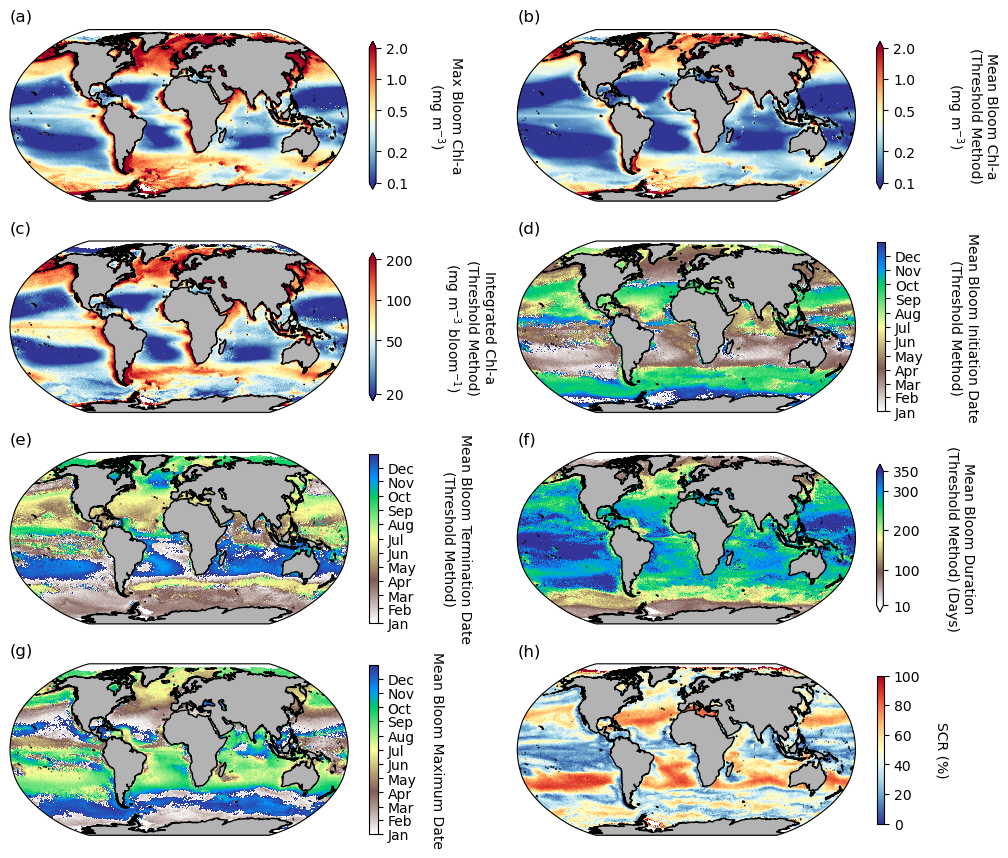

In [693]:
fig = figure(figsize=[12, 14], dpi=100)

ax1 = subplot2grid((4,2), (0,0), projection=ccrs.Robinson())
ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.max_chl.plot(ax=ax1, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=0.1, vmax=2, cmap=cm.RdYlBu_r, 
                                    norm=matplotlib.colors.LogNorm())
cb = colorbar(im, extend='both', shrink=0.35)
cb.set_label('Max Bloom Chl-a\n(mg m$^{-3}$)', rotation=270, labelpad=40)
cb.set_ticks([0.1, 0.2, 0.5, 1.0, 2.0])
cb.set_ticklabels(['0.1', '0.2', '0.5', '1.0', '2.0'])
cb.ax.minorticks_off()
ax1.set_title('(a)',loc='left')


ax2 = subplot2grid((4,2), (0,1), projection=ccrs.Robinson())
ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.mean_chl_ts.plot(ax=ax2, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=0.1, vmax=2, cmap=cm.RdYlBu_r, 
                                    norm=matplotlib.colors.LogNorm())
cb = colorbar(im, extend='both', shrink=0.35)
cb.set_label('Mean Bloom Chl-a\n(Threshold Method)\n(mg m$^{-3}$)', rotation=270, labelpad=60)
cb.set_ticks([0.1, 0.2, 0.5, 1.0, 2.0])
cb.set_ticklabels(['0.1', '0.2', '0.5', '1.0', '2.0'])
cb.ax.minorticks_off()
ax2.set_title('(b)',loc='left')



ax3 = subplot2grid((4,2), (1,0), projection=ccrs.Robinson())
ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.int_chl_ts.plot(ax=ax3, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=20, vmax=200, cmap=cm.RdYlBu_r, 
                                    norm=matplotlib.colors.LogNorm())
cb = colorbar(im, extend='both', shrink=0.35)
cb.set_label('Integrated Chl-a\n(Threshold Method)\n(mg m$^{-3}$ bloom$^{-1}$)', rotation=270, labelpad=60)
cb.set_ticks([20, 50, 100, 200])
cb.set_ticklabels(['20', '50', '100', '200'])
cb.ax.minorticks_off()
ax3.set_title('(c)',loc='left')


ax4 = subplot2grid((4,2), (1,1), projection=ccrs.Robinson())
ax4.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.initiation_ts.plot(ax=ax4, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap=cm.terrain_r,)
cb = colorbar(im, shrink=0.4, ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cb.set_label('Mean Bloom Initiation Date\n(Threshold Method)', rotation=270, labelpad=40)
ax4.set_title('(d)',loc='left')



ax51 = subplot2grid((4,2), (2,0), projection=ccrs.Robinson())
ax51.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.termination_ts.plot(ax=ax51, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap=cm.terrain_r,)
cb = colorbar(im, shrink=0.4, ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cb.set_label('Mean Bloom Termination Date\n(Threshold Method)', rotation=270, labelpad=40)
ax51.set_title('(e)',loc='left')


ax5 = subplot2grid((4,2), (2,1), projection=ccrs.Robinson())
ax5.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.duration_ts.plot(ax=ax5, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r,)
cb = colorbar(im, extend='both', shrink=0.35, ticks=[10, 100, 200, 300, 350])
cb.set_label('Mean Bloom Duration\n(Threshold Method) (Days)', rotation=270, labelpad=40)
ax5.set_title('(f)',loc='left')


ax6 = subplot2grid((4,2), (3,0), projection=ccrs.Robinson())

ax6.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = PHENO_25KM_MEAN.max_time.plot(ax=ax6, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap=cm.terrain_r)

cb = colorbar(im, shrink=0.4, ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cb.set_label('Mean Bloom Maximum Date', rotation=270, labelpad=20)
ax6.set_title('(g)',loc='left')



ax7 = subplot2grid((4,2), (3,1), projection=ccrs.Robinson())
#SCR_25KM

ax7.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
scr= SCR_25KM.chlor_a.mean('year')*100
im = scr.plot(ax=ax7, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=0, vmax=100, cmap=cm.RdYlBu_r)
cb = colorbar(im, shrink=0.35, ticks=[0,20,40,60,80,100])
cb.set_label('SCR (%)', rotation=270, labelpad=20)
ax7.set_title('(h)',loc='left')

fig.tight_layout()
subplots_adjust(hspace=-0.5)

fig.savefig(fig_dir+'FIGURE2_R2_ESSD.png',dpi=300)

# Select a few regional phenology case studies to compare

## Berring Sea https://www.sciencedirect.com/science/article/pii/S0079661123002197#f0015

Text(0.0, 1.0, '(a) Mean Bloom Maximum Date')

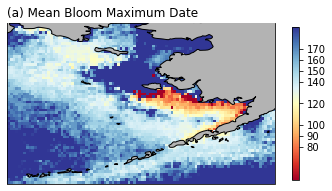

In [252]:
extent = [-180,-155, 51, 66]

# Subplot 3
ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'land', '50m', edgecolor='k', facecolor='0.7'
    ),
    zorder=5,
)

im = PHENO_25KM_MEAN.max_time.plot(ax=ax, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=50, vmax=190, cmap='RdYlBu')

cb = colorbar(im, shrink=0.7, ticks=[80,90,100,120,140,150,160,170])
#cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#cb.set_label('Mean Bloom Maximum Date', rotation=270, labelpad=20)
ax.set_title('(a) Mean Bloom Maximum Date',loc='left')


### M2 and M5 mooring stations compare with Figure 2 from Nielsen et al. 2023

In [270]:
#M2 = 56.87°N, 164.05°W
#M5 = 59.92°N, 171.73°W

# Define location of insitu data
la1 = 56.87
lo1= -164.05

# Subset the dataset for the given area
m2 = PHENO_25KM.sel(lon=lo1, lat=la1, method='nearest')

# Define location of insitu data
la1 = 59.92
lo1= -171.73

# Subset the dataset for the given area
m5 = PHENO_25KM.sel(lon=lo1, lat=la1, method='nearest')

In [257]:
print('max time:' +str(st.circmean(m2.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± '+ str(st.circstd(m2.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit')))


max time:145.2336679148523 ± 57.975825730478576


In [258]:
print('max time:' +str(st.circmean(m5.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± '+ str(st.circstd(m5.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit')))

max time:147.35623499899623 ± 66.0572709580158


## Saronikos Gulf (https://www.nature.com/articles/s41598-023-48254-7)

In [155]:
# Define location of insitu data
la1 = 37.89 
lo1= 23.69

# Subset the dataset for the given area
region = PHENO_4KM.sel(lon=lo1, lat=la1, method='nearest')
chl_r = chl_25km.chlor_a.sel(lon=lo1, lat=la1, method='nearest')

p2=region.sel(year = slice(2005,2015))
p1=region.sel(year = slice(1997,2005))

### P2 station mean phenology

In [162]:
print('term cs: '+ str(st.circmean(p2.termination_cs.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± ' + str(st.circstd(p2.termination_cs.dt.dayofyear, high=365, low=1, nan_policy='omit'))    )
print('init cs: ' +str(st.circmean(p2.initiation_cs.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± ' +str(st.circstd(p2.initiation_cs.dt.dayofyear, high=365, low=1, nan_policy='omit')) )
print('max time:' +str(st.circmean(p2.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± '+ str(st.circstd(p2.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit')))
print('duration: '+ str(p2.duration_cs.mean().values)+' ± '+ str(p2.duration_cs.std().values))

term cs: 194.91559915284694 ± 27.725916424623303
init cs: 267.18053642962775 ± 45.52659486993376
max time:55.762905763484085 ± 31.573866139895127
duration: 286.90909090909093 ± 45.11289786434705


## https://pmc.ncbi.nlm.nih.gov/articles/PMC11063190/

In [276]:
la1 = 37.87 
lo1= 23.64
# Subset the dataset for the given area
region = PHENO_4KM.sel(lon=lo1, lat=la1, method='nearest')
chl_r = chl_25km.chlor_a.sel(lon=lo1, lat=la1, method='nearest')
S11=region.sel(year = slice(1997,2017))

In [277]:
print('term cs: '+ str(st.circmean(S11.termination_cs.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± ' + str(st.circstd(S11.termination_cs.dt.dayofyear, high=365, low=1, nan_policy='omit'))    )
print('init cs: ' +str(st.circmean(S11.initiation_cs.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± ' +str(st.circstd(S11.initiation_cs.dt.dayofyear, high=365, low=1, nan_policy='omit')) )
print('max time:' +str(st.circmean(S11.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit'))+' ± '+ str(st.circstd(S11.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit')))
print('duration: '+ str(S11.duration_cs.mean().values)+' ± '+ str(S11.duration_cs.std().values))

term cs: 203.55326704914782 ± 27.66837728831851
init cs: 273.71764433402507 ± 36.5068068350016
max time:60.80045979631217 ± 30.212389470904483
duration: 297.25 ± 37.1777823437601


##  RED SEA https://www.sciencedirect.com/science/article/pii/S0034425715000371?via%3Dihub

Compare winter initatiation date from Racault et al. 2015 with our initation date (we dont account for summer and winter indices)
> Northern Red Sea winter initaiton (01–08 Nov)

> Southern Central Red Sea winter initiation (16–23 Oct)

> Southern Red Sea (30 Sep–07 Oct)

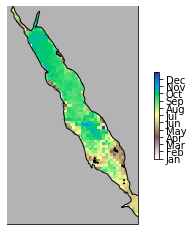

In [854]:
# Subplot 3
extent = [32,44, 10, 30]

ax = plt.subplot2grid((1, 1), (0, 0), projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(
    cfeature.NaturalEarthFeature(
        'physical', 'land', '50m', edgecolor='k', facecolor='0.7'
    ),
    zorder=5,
)

im = PHENO_25KM_MEAN.initiation_cs.plot(ax=ax, transform=ccrs.PlateCarree(), 
                               add_colorbar=False,vmin=1, vmax=365, cmap=cm.terrain_r)


cb = colorbar(im, shrink=0.4, ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
cb.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


# Section 3.2 Comparisons in phenology detection approach

## compare other metrics

In [681]:
import xarray as xr

# Define the circular day difference function
def circular_day_difference(yearday1, yearday2, year_length=365):
    # Calculate direct difference
    diff = yearday1 - yearday2

    # Adjust for circular wrap-around
    if abs(diff) > year_length / 2:
        if diff > 0:
            diff = diff - year_length
        else:
            diff = diff + year_length

    return diff

# Apply the circular day difference function to xarray objects
def apply_circular_day_difference(yearday1, yearday2, year_length=365):
    return xr.apply_ufunc(
        circular_day_difference,
        yearday1, yearday2,  # Input arrays
        kwargs={'year_length': year_length},  # Additional arguments
        vectorize=True  # Ensures the function is applied element-wise
    )


In [682]:
# Termination, if red, TS later termination\
# Initation, if blue, TS earlier initaition
ts_cs = apply_circular_day_difference(PHENO_25KM_MEAN.initiation_ts,PHENO_25KM_MEAN.initiation_cs)


/apps/user/erth0834/anaconda3-2021.05/envs/bp12_eval/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


# Figure A3

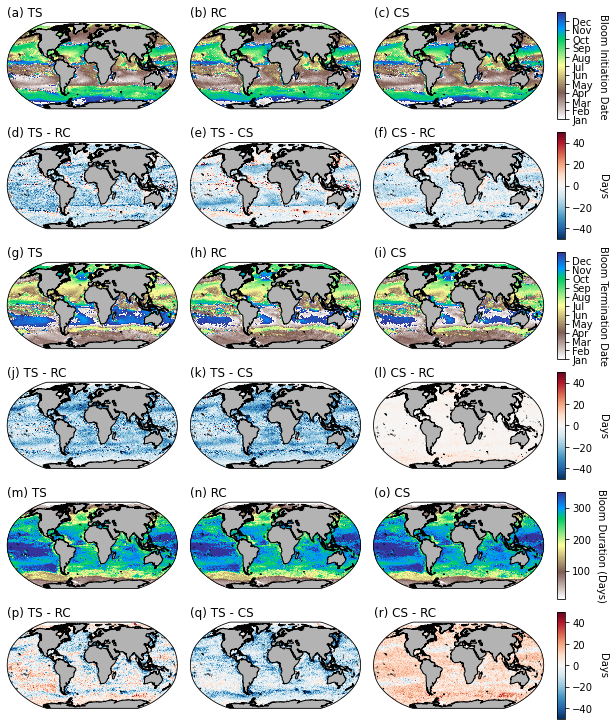

In [686]:

fig = plt.figure(figsize=[10, 13])  # Increase figure height to fit more rows
gs = gridspec.GridSpec(6, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1, hspace=0.12)

# First Row (Initiation)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im1 = PHENO_25KM_MEAN.initiation_ts.plot(ax=ax1, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap='terrain_r')
ax1.set_title('(a) TS', loc='left')

ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im2 = PHENO_25KM_MEAN.initiation_rc.plot(ax=ax2, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap='terrain_r')
ax2.set_title('(b) RC', loc='left')

ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())
ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im3 = PHENO_25KM_MEAN.initiation_cs.plot(ax=ax3, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap='terrain_r')
ax3.set_title('(c) CS', loc='left')

# Colorbar for the first row (Initiation)
cb_ax1 = fig.add_subplot(gs[0, 3])
cb1 = plt.colorbar(im1, cax=cb_ax1, shrink=0.3, ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
cb1.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cb1.set_label('Bloom Initiation Date', rotation=270, labelpad=15)

# Second Row (Initiation Differences)
ts_rc = apply_circular_day_difference(PHENO_25KM_MEAN.initiation_ts, PHENO_25KM_MEAN.initiation_rc)
ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson())
ax4.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im4 = ts_rc.plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax4.set_title('(d) TS - RC', loc='left')

ts_cs = apply_circular_day_difference(PHENO_25KM_MEAN.initiation_ts, PHENO_25KM_MEAN.initiation_cs)
ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson())
ax5.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im5 = ts_cs.plot(ax=ax5, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax5.set_title('(e) TS - CS', loc='left')

cs_rc = apply_circular_day_difference(PHENO_25KM_MEAN.initiation_cs, PHENO_25KM_MEAN.initiation_rc)
ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.Robinson())
ax6.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im6 = cs_rc.plot(ax=ax6, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax6.set_title('(f) CS - RC', loc='left')

# Colorbar for the second row (Initiation Differences)
cb_ax2 = fig.add_subplot(gs[1, 3])
cb2 = plt.colorbar(im4, cax=cb_ax2, shrink=0.1)
cb2.set_label('Days', rotation=270, labelpad=15)

# Third Row (Termination)
ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.Robinson())
ax7.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im7 = PHENO_25KM_MEAN.termination_ts.plot(ax=ax7, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap='terrain_r')
ax7.set_title('(g) TS', loc='left')

ax8 = fig.add_subplot(gs[2, 1], projection=ccrs.Robinson())
ax8.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im8 = PHENO_25KM_MEAN.termination_rc.plot(ax=ax8, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap='terrain_r')
ax8.set_title('(h) RC', loc='left')

ax9 = fig.add_subplot(gs[2, 2], projection=ccrs.Robinson())
ax9.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im9 = PHENO_25KM_MEAN.termination_cs.plot(ax=ax9, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=1, vmax=365, cmap='terrain_r')
ax9.set_title('(i) CS', loc='left')

# Colorbar for the third row (Termination)
cb_ax3 = fig.add_subplot(gs[2, 3])
cb3 = plt.colorbar(im7, cax=cb_ax3, shrink=0.3, ticks=[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
cb3.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cb3.set_label('Bloom Termination Date', rotation=270, labelpad=15)

# Fourth Row (Termination Differences)
ts_rc_term = apply_circular_day_difference(PHENO_25KM_MEAN.termination_ts,PHENO_25KM_MEAN.termination_rc)
ax10 = fig.add_subplot(gs[3, 0], projection=ccrs.Robinson())
ax10.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im10 = ts_rc_term.plot(ax=ax10, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax10.set_title('(j) TS - RC', loc='left')

ts_cs_term = apply_circular_day_difference(PHENO_25KM_MEAN.termination_ts,PHENO_25KM_MEAN.termination_cs)
ax11 = fig.add_subplot(gs[3, 1], projection=ccrs.Robinson())
ax11.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im11 = ts_cs_term.plot(ax=ax11, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax11.set_title('(k) TS - CS', loc='left')

cs_rc_term = apply_circular_day_difference(PHENO_25KM_MEAN.termination_cs,PHENO_25KM_MEAN.termination_rc)
ax12 = fig.add_subplot(gs[3, 2], projection=ccrs.Robinson())
ax12.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im12 = cs_rc_term.plot(ax=ax12, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax12.set_title('(l) CS - RC', loc='left')

# Colorbar for the fourth row (Termination Differences)
cb_ax4 = fig.add_subplot(gs[3, 3])
cb4 = plt.colorbar(im10, cax=cb_ax4, shrink=0.1)
cb4.set_label('Days', rotation=270, labelpad=15)



# Fifth Row (Duration)
ax13 = fig.add_subplot(gs[4, 0], projection=ccrs.Robinson())
ax13.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im13 = PHENO_25KM_MEAN.duration_ts.plot(ax=ax13, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r)
ax13.set_title('(m) TS', loc='left')

ax14 = fig.add_subplot(gs[4, 1], projection=ccrs.Robinson())
ax14.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im14 = PHENO_25KM_MEAN.duration_rc.plot(ax=ax14, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r)
ax14.set_title('(n) RC', loc='left')

ax15 = fig.add_subplot(gs[4, 2], projection=ccrs.Robinson())
ax15.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im15 = PHENO_25KM_MEAN.duration_cs.plot(ax=ax15, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r)
ax15.set_title('(o) CS', loc='left')

# Colorbar for the fifth row (Duration)
cb_ax5 = fig.add_subplot(gs[4, 3])
cb5 = plt.colorbar(im13, cax=cb_ax5, shrink=0.3)
cb5.set_label('Bloom Duration (Days)', rotation=270, labelpad=15)

# Sixth Row (Duration Differences)
ts_rc_dur = PHENO_25KM_MEAN.duration_ts - PHENO_25KM_MEAN.duration_rc
ax16 = fig.add_subplot(gs[5, 0], projection=ccrs.Robinson())
ax16.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im16 = ts_rc_dur.plot(ax=ax16, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax16.set_title('(p) TS - RC', loc='left')

ts_cs_dur = PHENO_25KM_MEAN.duration_ts - PHENO_25KM_MEAN.duration_cs
ax17 = fig.add_subplot(gs[5, 1], projection=ccrs.Robinson())
ax17.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im17 = ts_cs_dur.plot(ax=ax17, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax17.set_title('(q) TS - CS', loc='left')

cs_rc_dur = PHENO_25KM_MEAN.duration_cs - PHENO_25KM_MEAN.duration_rc
ax18 = fig.add_subplot(gs[5, 2], projection=ccrs.Robinson())
ax18.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k', facecolor='0.7'), zorder=5)
im18 = cs_rc_dur.plot(ax=ax18, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-50, vmax=50, cmap='RdBu_r',extend='both')
ax18.set_title('(r) CS - RC', loc='left')

# Colorbar for the sixth row (Duration Differences)
cb_ax6 = fig.add_subplot(gs[5, 3])
cb6 = plt.colorbar(im16, cax=cb_ax6, shrink=0.05)
cb6.set_label('Days', rotation=270, labelpad=15)

#plt.show()
fig.savefig(fig_dir + 'FIGURE2_A2_ESSD_METHODS_DIFF_MAPS.png', dpi=300)


# FIGURE 3: Standard deviation of Methods

In [687]:
def process_doy(arr):
    doy = st.circmean(arr, high=365, low=1, nan_policy='omit')
    doy_st = st.circstd(arr, high=365, low=1, nan_policy='omit')
    return doy, doy_st

init_means = xr.concat([PHENO_25KM_MEAN.initiation_ts,
                       PHENO_25KM_MEAN.initiation_cs,
                       PHENO_25KM_MEAN.initiation_rc], dim='method')

init_stats = xr.apply_ufunc(
    process_doy,
    init_means,
    input_core_dims=[['method']],
    output_core_dims=[[], []],
    output_dtypes=[float, float],
    vectorize=True)

init_res = xr.Dataset({
    'circ_mean': init_stats[0],
    'circ_std': init_stats[1]})

term_means = xr.concat([PHENO_25KM_MEAN.termination_ts,
                       PHENO_25KM_MEAN.termination_cs,
                       PHENO_25KM_MEAN.termination_rc], dim='method')

term_stats = xr.apply_ufunc(
    process_doy,
    term_means,
    input_core_dims=[['method']],
    output_core_dims=[[], []],
    output_dtypes=[float, float],
    vectorize=True)

term_res = xr.Dataset({
    'circ_mean': term_stats[0],
    'circ_std': term_stats[1]})


In [688]:
dura_means = xr.concat([PHENO_25KM_MEAN.duration_ts,
                       PHENO_25KM_MEAN.duration_cs,
                       PHENO_25KM_MEAN.duration_rc], dim='method')

dura_std = dura_means.std('method')


chl_int = xr.concat([PHENO_25KM_MEAN.int_chl_ts,
                       PHENO_25KM_MEAN.int_chl_cs,
                       PHENO_25KM_MEAN.int_chl_rc], dim='method')

chl_int_std = chl_int.std('method')



chl_means = xr.concat([PHENO_25KM_MEAN.mean_chl_ts,
                       PHENO_25KM_MEAN.mean_chl_cs,
                       PHENO_25KM_MEAN.mean_chl_rc], dim='method')

chl_means_std = chl_means.std('method')

/var/tmp/pbs.6302016.sched01/ipykernel_17558/803462723.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/var/tmp/pbs.6302016.sched01/ipykernel_17558/803462723.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


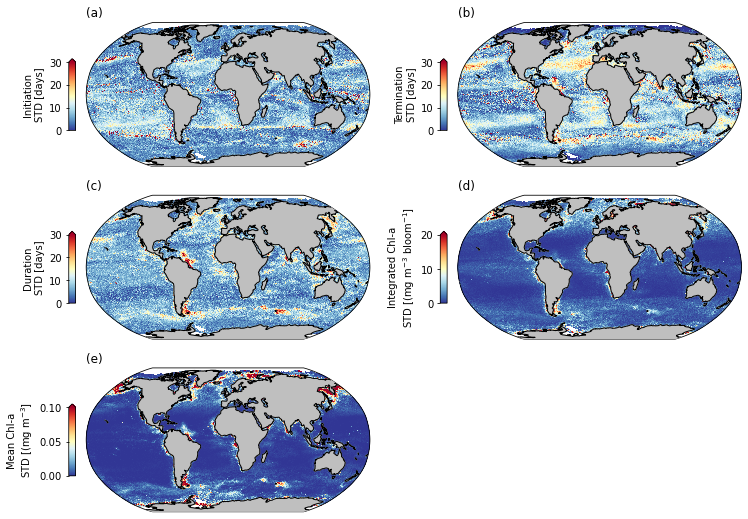

In [690]:
fig = figure(figsize=[13,9])
gs = GridSpec(3,2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax1.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
im = init_res['circ_std'].plot(ax=ax1, vmin=0, vmax=30, cmap='RdYlBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
cbar = fig.colorbar(im, extend='max',location='left', shrink=0.5, pad = 0.03, aspect=10)
cbar.set_label('Initiation\nSTD [days]')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')
ax1.set_title('(a)',loc='left')

ax4 = fig.add_subplot(gs[0,1], projection=ccrs.Robinson())
ax4.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax4.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
im = term_res['circ_std'].plot(ax=ax4, vmin=0, vmax=30, cmap='RdYlBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
cbar = fig.colorbar(im, extend='max',location='left',shrink=0.5, pad = 0.03, aspect=10)
cbar.set_label('Termination\nSTD [days]')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')
ax4.set_title('(b)',loc='left')

ax7 = fig.add_subplot(gs[1,0], projection=ccrs.Robinson())
ax7.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax7.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
im = dura_std.plot(ax=ax7, vmin=0, vmax=30, cmap='RdYlBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax7.set_title('(c)',loc='left')
cbar = fig.colorbar(im, extend='max',location='left',shrink=0.5, pad = 0.03, aspect=10)
cbar.set_label('Duration\nSTD [days]')
cbar.ax.yaxis.set_label_position('left')


ax10 = fig.add_subplot(gs[1,1], projection=ccrs.Robinson())
ax10.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax10.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
im = chl_int_std.plot(ax=ax10, vmin=0, vmax=20, cmap='RdYlBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax10.set_title('(d)',loc='left')
cbar = fig.colorbar(im,extend='max', location='left',shrink =0.5, pad = 0.03, aspect=10)
cbar.set_label('Integrated Chl-a\nSTD [(mg m$^{-3}$ bloom$^{-1}$]')
cbar.ax.yaxis.set_label_position('left')

ax13 = fig.add_subplot(gs[2,0], projection=ccrs.Robinson())
ax13.add_feature(cartopy.feature.LAND, facecolor='0.75', zorder=5)
ax13.add_feature(cartopy.feature.COASTLINE, linewidth=1, zorder=5)
im = chl_means_std.plot(ax=ax13, vmin=0, vmax=.1, cmap='RdYlBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
cbar = fig.colorbar(im,extend='max',location='left',shrink=0.5, pad = 0.03, aspect=10)
cbar.set_label('Mean Chl-a\nSTD [(mg m$^{-3}$]')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')
ax13.set_title('(e)',loc='left')

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)


plt.tight_layout()

plt.show()
fig.savefig(fig_dir+'FIGURE3_R2_ESSD_PHENOLOGY_STDMETHODS_FIN.png',dpi=300)


In [100]:
dura_std.mean()

<xarray.DataArray 'duration_ts' ()>
array(6.99743506)

In [99]:
init_res['circ_std'].mean()

<xarray.DataArray 'circ_std' ()>
array(7.01468072)

# FIGURE A1

Time-series of mean clim bloom cycle with mean pheno metrics x 3 at
BATS, HOTS, SOTS, PAPS

In [694]:
init1 = PHENO_25KM.initiation_ts
term1 = PHENO_25KM.termination_ts
init2 = PHENO_25KM.initiation_cs
term2 = PHENO_25KM.termination_cs
init3 = PHENO_25KM.initiation_rc
term3 = PHENO_25KM.termination_rc


/var/tmp/pbs.6302016.sched01/ipykernel_17558/972736711.py:187: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles, handles=[p3, p4, p1a, p1b, p1c, p2a, p2b, p2c, p6a, p6b, p6c],


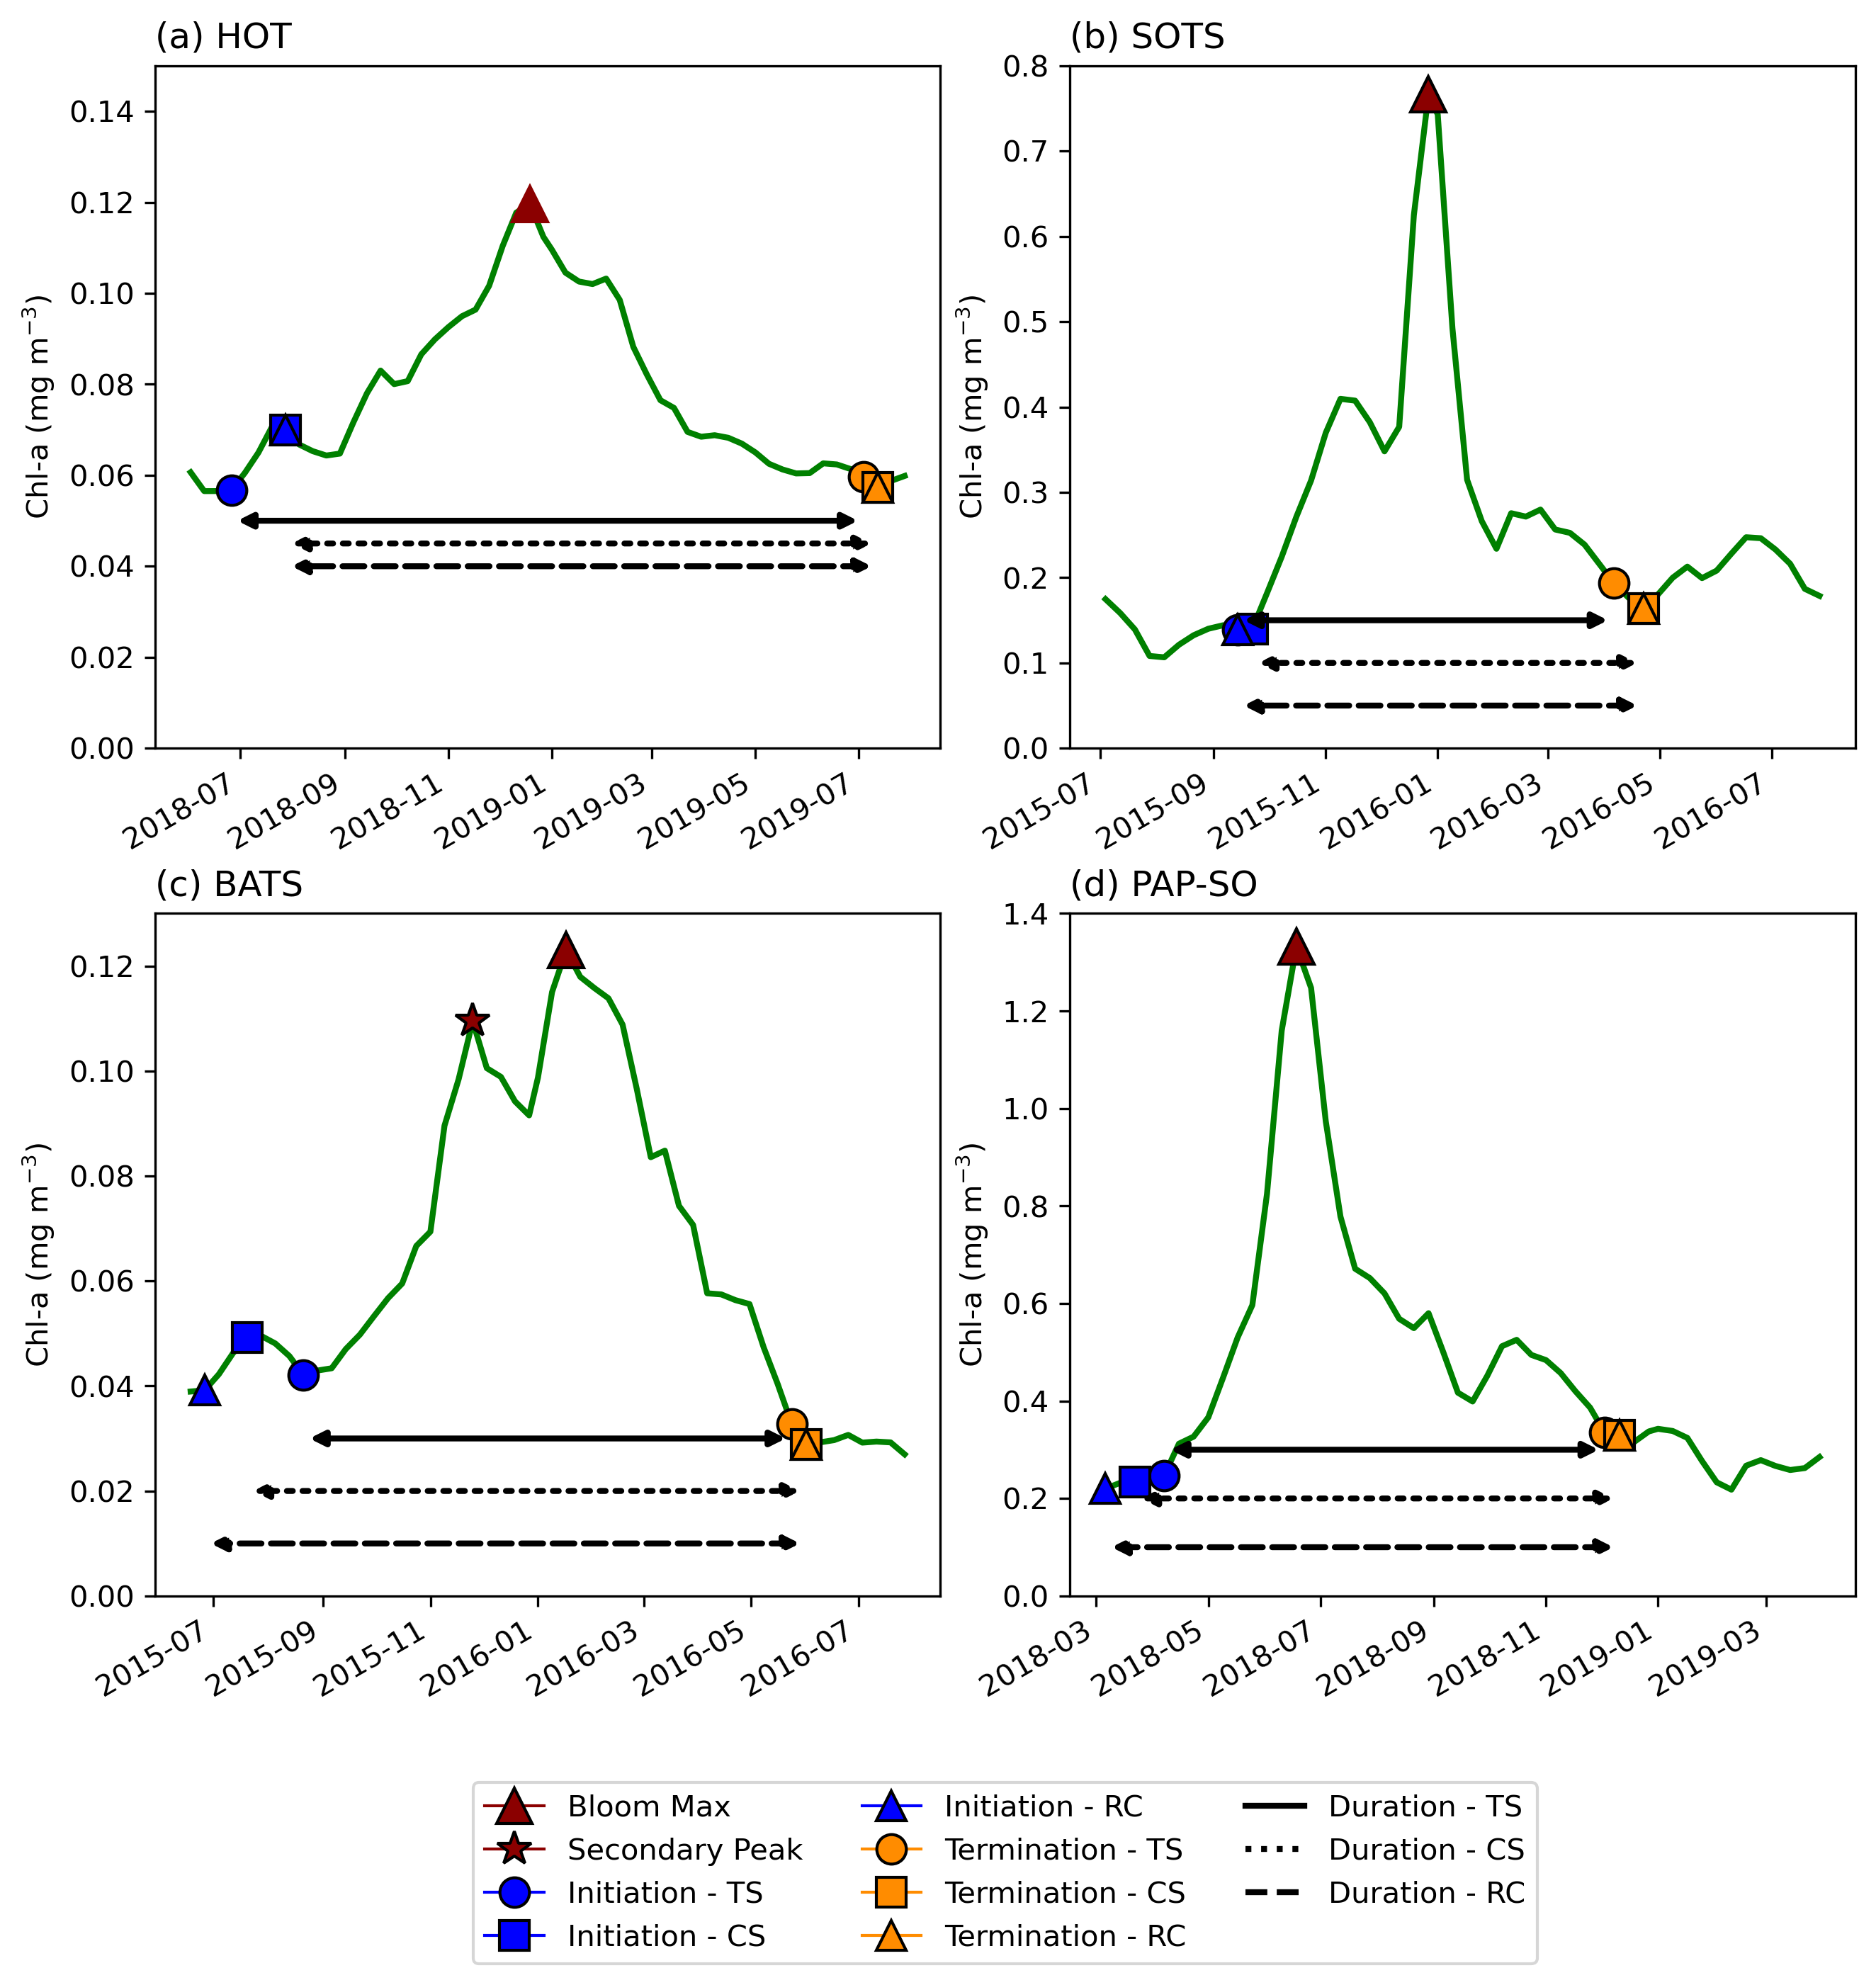

In [695]:
fig = figure(figsize=[10, 9], dpi=300)

ax = subplot2grid((2,2), (0,0))
lat = 22.75
lon = -158
# Hawaiin Observion 
region = chl_25km.chlor_a.sel(lat=lat, lon=lon, method='nearest')
r1 = region.sel(time=slice('2018-06-01','2019-07-31')).to_dataframe()
i1 = init1.sel(lat=lat, lon=lon, year=2019, method='nearest').values
t1 = term1.sel(lat=lat, lon=lon, year=2019, method='nearest').values
i2 = init2.sel(lat=lat, lon=lon, year=2019, method='nearest').values
t2 = term2.sel(lat=lat, lon=lon, year=2019, method='nearest').values
i3 = init3.sel(lat=lat, lon=lon, year=2019, method='nearest').values
t3 = term3.sel(lat=lat, lon=lon, year=2019, method='nearest').values
r1.chlor_a.plot(ax=ax, color='green', label='',lw=2)

y1 = region.sel(time = i1, method='nearest').values
y2 = region.sel(time = i2, method='nearest').values
y3 = region.sel(time = i3, method='nearest').values
ax.plot(i1, y1, marker='o', color='blue', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(i2, y2, marker='s', color='blue', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(i3, y3, marker='^', color='blue', lw=1, ms=10,markeredgecolor= 'black')
y1 = region.sel(time = t1, method='nearest').values# + 0.075
y2 = region.sel(time = t2, method='nearest').values 
y3 = region.sel(time = t3, method='nearest').values - 0.00001
ax.plot(t1, y1, marker='o', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t2, y2, marker='s', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t3, y3, marker='^', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
x = r1.idxmax().chlor_a
y = r1.max().chlor_a
ax.plot(x, y, marker='^', color='darkred', lw=0, ms=12, label='Peak')

ax.annotate('', xy=(i1, 0.05), xytext=(t1, 0.05), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2))
ax.annotate('', xy=(i2, 0.045), xytext=(t2, 0.045), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls=':'))
ax.annotate('', xy=(i3, 0.04), xytext=(t3, 0.04), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls='--'))

ax.set_ylim(0.0, 0.15)
ax.set_xlabel('')
ax.set_ylabel('Chl-a (mg m$^{-3}$)')
ax.set_title('(a) HOT',loc='left')

#----------------------------SOTS -------------------
ax = subplot2grid((2,2), (0,1))
lat = -47
lon = 141

region = chl_25km.chlor_a.sel(lat=lat, lon=lon, method='nearest')
r1 = region.sel(time=slice('2015-07-01','2016-07-31')).to_dataframe()
i1 = init1.sel(lat=lat, lon=lon, year=2015, method='nearest').values
t1 = term1.sel(lat=lat, lon=lon, year=2015, method='nearest').values
i2 = init2.sel(lat=lat, lon=lon, year=2015, method='nearest').values
t2 = term2.sel(lat=lat, lon=lon, year=2015, method='nearest').values
i3 = init3.sel(lat=lat, lon=lon, year=2015, method='nearest').values
t3 = term3.sel(lat=lat, lon=lon, year=2015, method='nearest').values
r1.chlor_a.plot(ax=ax, color='green', label='',lw=2)

y1 = region.sel(time = i1, method='nearest').values
y2 = region.sel(time = i2, method='nearest').values
y3 = region.sel(time = i3, method='nearest').values
ax.plot(i1, y1, marker='o', color='blue', lw=1, ms=10,markeredgecolor= 'black' )
ax.plot(i2, y2, marker='s', color='blue', lw=1, ms=10,markeredgecolor= 'black' )
ax.plot(i3, y3, marker='^', color='blue', lw=1, ms=10,markeredgecolor= 'black' )
y1 = region.sel(time = t1, method='nearest').values# + 0.075
y2 = region.sel(time = t2, method='nearest').values 
y3 = region.sel(time = t3, method='nearest').values - 0.00001# - 0.075
ax.plot(t1, y1, marker='o', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t2, y2, marker='s', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t3, y3, marker='^', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')

x = r1.idxmax().chlor_a
y = r1.max().chlor_a
ax.plot(x, y, marker='^', color='darkred', lw=1, ms=12,markeredgecolor= 'black',label='Peak')
ax.annotate('', xy=(i1, 0.15), xytext=(t1, 0.15), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2))
ax.annotate('', xy=(i2, 0.1), xytext=(t2, 0.1), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls=':'))
ax.annotate('', xy=(i3, 0.05), xytext=(t3, 0.05), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls='--'))

ax.set_ylim(0, 0.8)
ax.set_xlabel('')
ax.set_ylabel('Chl-a (mg m$^{-3}$)')
ax.set_title('(b) SOTS',loc='left')


#-------------------BATS ---------------------#

ax = subplot2grid((2,2), (1,0))
lat = 31.667
lon = -64.1667

region = chl_25km.chlor_a.sel(lat=lat, lon=lon, method='nearest')
r1 = region.sel(time=slice('2015-06-15','2016-07-31')).to_dataframe()
i1 = init1.sel(lat=lat, lon=lon, year=2016, method='nearest').values
t1 = term1.sel(lat=lat, lon=lon, year=2016, method='nearest').values
i2 = init2.sel(lat=lat, lon=lon, year=2016, method='nearest').values
t2 = term2.sel(lat=lat, lon=lon, year=2016, method='nearest').values
i3 = init3.sel(lat=lat, lon=lon, year=2016, method='nearest').values
t3 = term3.sel(lat=lat, lon=lon, year=2016, method='nearest').values
r1.chlor_a.plot(ax=ax, color='green', label='',lw=2)

y1 = region.sel(time = i1, method='nearest').values
y2 = region.sel(time = i2, method='nearest').values
y3 = region.sel(time = i3, method='nearest').values
ax.plot(i1, y1, marker='o', color='blue', lw=1, ms=10,markeredgecolor= 'black' )
ax.plot(i2, y2, marker='s', color='blue', lw=1, ms=10,markeredgecolor= 'black' )
ax.plot(i3, y3, marker='^', color='blue', lw=1, ms=10,markeredgecolor= 'black' )
y1 = region.sel(time = t1, method='nearest').values# + 0.075
y2 = region.sel(time = t2, method='nearest').values 
y3 = region.sel(time = t3, method='nearest').values# - 0.075
ax.plot(t1, y1, marker='o', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t2, y2, marker='s', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t3, y3, marker='^', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')

x = r1.idxmax().chlor_a
y = r1.max().chlor_a
ax.plot(x, y, marker='^', color='darkred',  lw=1, ms=12,markeredgecolor= 'black', label='Peak')
x = r1.iloc[20].name
y = r1.iloc[20].chlor_a
ax.plot(x, y, marker='*', color='darkred',  lw=1, ms=12,markeredgecolor= 'black', label='Peak')

ax.annotate('', xy=(i1, 0.03), xytext=(t1, 0.03), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2))
ax.annotate('', xy=(i2, 0.02), xytext=(t2, 0.02), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls=':'))
ax.annotate('', xy=(i3, 0.01), xytext=(t3, 0.01), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls='--'))

ax.set_ylim(0, 0.13)
ax.set_xlabel('')
ax.set_ylabel('Chl-a (mg m$^{-3}$)')
ax.set_title('(c) BATS',loc='left')


#-------------------PAP-SO ---------------------#

ax = subplot2grid((2,2), (1,1))
lat = 48.8333
lon = -16.5

region = chl_25km.chlor_a.sel(lat=lat, lon=lon, method='nearest')
r1 = region.sel(time=slice('2018-03-01','2019-03-31')).to_dataframe()
i1 = init1.sel(lat=lat, lon=lon, year=2018, method='nearest').values
t1 = term1.sel(lat=lat, lon=lon, year=2018, method='nearest').values
i2 = init2.sel(lat=lat, lon=lon, year=2018, method='nearest').values
t2 = term2.sel(lat=lat, lon=lon, year=2018, method='nearest').values
i3 = init3.sel(lat=lat, lon=lon, year=2018, method='nearest').values
t3 = term3.sel(lat=lat, lon=lon, year=2018, method='nearest').values
r1.chlor_a.plot(ax=ax, color='green', label='',lw=2)

y1 = region.sel(time = i1, method='nearest').values
y2 = region.sel(time = i2, method='nearest').values
y3 = region.sel(time = i3, method='nearest').values
ax.plot(i1, y1, marker='o', color='blue', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(i2, y2, marker='s', color='blue', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(i3, y3, marker='^', color='blue', lw=1, ms=10,markeredgecolor= 'black')
y1 = region.sel(time = t1, method='nearest').values# + 0.075
y2 = region.sel(time = t2, method='nearest').values 
y3 = region.sel(time = t3, method='nearest').values# - 0.075
ax.plot(t1, y1, marker='o', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t2, y2, marker='s', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')
ax.plot(t3, y3, marker='^', color='darkorange', lw=1, ms=10,markeredgecolor= 'black')

x = r1.idxmax().chlor_a
y = r1.max().chlor_a
ax.plot(x, y, marker='^', color='darkred', lw=1, ms=12,markeredgecolor= 'black', label='Peak')

ax.annotate('', xy=(i1, 0.3), xytext=(t1, 0.3), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2))
ax.annotate('', xy=(i2, 0.2), xytext=(t2, 0.2), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls=':'))
ax.annotate('', xy=(i3, 0.1), xytext=(t3, 0.1), arrowprops=dict(arrowstyle= '<|-|>', color='k', lw=2, ls='--'))
ax.set_ylim(0, 1.4)
ax.set_xlabel('')
ax.set_ylabel('Chl-a (mg m$^{-3}$)')
ax.set_title('(d) PAP-SO',loc='left')
p1a = mlines.Line2D([], [], color='blue', marker='o', lw=1, ms=10,markeredgecolor= 'black', label='Initiation - TS')
p1b = mlines.Line2D([], [], color='blue', marker='s', lw=1, ms=10,markeredgecolor= 'black', label='Initiation - CS')
p1c = mlines.Line2D([], [], color='blue', marker='^', lw=1, ms=10,markeredgecolor= 'black', label='Initiation - RC')
p2a = mlines.Line2D([], [], color='darkorange', marker='o', lw=1, ms=10,markeredgecolor= 'black', label='Termination - TS')
p2b = mlines.Line2D([], [], color='darkorange', marker='s', lw=1, ms=10,markeredgecolor= 'black', label='Termination - CS')
p2c = mlines.Line2D([], [], color='darkorange', marker='^', lw=1, ms=10,markeredgecolor= 'black', label='Termination - RC')
p3 = mlines.Line2D([], [], color='darkred', marker='^', lw=1, ms=12,markeredgecolor= 'black',label='Bloom Max')
p4 = mlines.Line2D([], [], color='darkred', marker='*', lw=1,ms=12,markeredgecolor= 'black', label='Secondary Peak')
p6a = mlines.Line2D([], [], color='k', lw=2, label='Duration - TS')
p6b = mlines.Line2D([], [], color='k', ls=':', lw=2, label='Duration - CS')
p6c = mlines.Line2D([], [], color='k', ls='--', lw=2, label='Duration - RC')



handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, handles=[p3, p4, p1a, p1b, p1c, p2a, p2b, p2c, p6a, p6b, p6c], 
          ncol=3, fontsize=10, bbox_to_anchor =(0.5,-.1), loc='lower center')
fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

fig.savefig(fig_dir+'FIGUREA1_R2_ESSD_PHENOLOGY_LONGTERM_SITE_COMAPRE_LEG.png', bbox_inches='tight',dpi=300)


# COMPARISON WITH IN SITU HPLC DATA

In [ ]:
# Load pheno from satellite derived:
lat_hot, lon_hot = 22.75, -158  # Hawaiian Ocean Time-series (HOT)
hot_pheno_sat = PHENO_25KM.sel(lat=lat_hot, lon=lon_hot, method='nearest')

lat_bats, lon_bats = 31.667, -64.1667  # Bermuda Atlantic Time-series (BATS)
bats_pheno_sat = PHENO_25KM.sel(lat=lat_bats, lon=lon_bats, method='nearest')


## DATA COMPILATION FROM VALENTA https://doi.pangaea.de/10.1594/PANGAEA.941318

In [873]:
filename= 'insitudb_chla_new.csv'
df = pd.read_csv(filename, on_bad_lines='skip') 
df_bats = df[df['chla_hplc_dataset'] == 'bats']
df_hot = df[df['chla_hplc_dataset'] == 'hot']

# Calculate the phenology indices on the mooring time-series 

#### Setting up BATS data

In [874]:
df_bats['time'] = pd.to_datetime(df_bats['time'])
# Set index before converting to Xarray
df_bats = df_bats.set_index(["time"])
# Convert to Xarray Dataset
ds_bats = df_bats.to_xarray()
ds_bats["time"] = ds_bats["time"].astype("datetime64[ns]")


/var/tmp/pbs.6302016.sched01/ipykernel_17558/239751996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bats['time'] = pd.to_datetime(df_bats['time'])


#### Setting up HOT data

In [875]:
df_hot['time'] = pd.to_datetime(df_hot['time'])
# Set index before converting to Xarray
df_hot = df_hot.set_index(["time"])
# Convert to Xarray Dataset
ds_hot = df_hot.to_xarray()
ds_hot["time"] = ds_hot["time"].astype("datetime64[ns]")
#ds_hot_5yrs = ds_hot.sel(time=slice('1998-01-01', '2016-12-31'))

/var/tmp/pbs.6302016.sched01/ipykernel_17558/542277170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hot['time'] = pd.to_datetime(df_hot['time'])


### Clim mean to centre bloom slice

#### Bats station clean up, calc clim 

In [914]:
# Define the new time grid with 8-day intervals
new_time = np.arange(ds_bats.time.min().values, ds_bats.time.max().values, np.timedelta64(8, 'D'))
# Interpolate onto the new time grid
ds_bats_8day = ds_bats.interp(time=new_time,method='linear')
# Compute z-scores for the time series (remove funky outliers)
z_scores = np.abs(zscore(ds_bats_8day.chla_hplc, nan_policy='omit'))
ds_bats_8day['chla_hplc_cleaned'] = ds_bats_8day.chla_hplc.where(z_scores < 5)
ds_bats_8day['chla_hplc_cleaned'] = ds_bats_8day.chla_hplc_cleaned.interpolate_na(dim='time' ,method='linear')
# Rolling mean with a window of 3 time steps
ds_bats_8day['chla_hplc_smoothed'] = ds_bats_8day.chla_hplc_cleaned.rolling(time=3, center=True,min_periods=1,).mean()
xds1_bats = ds_bats_8day['chla_hplc_smoothed']#.where(~time_mask)
# Define the time period to mask
start_time = pd.to_datetime('2004-11')
end_time = pd.to_datetime('2007-07')
# Create a mask for the time period with missing data
time_mask = (xds1_bats.time >= start_time) & (xds1_bats.time <= end_time)
# Apply the mask to the dataset (where missing data)
xds1_bats = xds1_bats.where(~time_mask)

## calculate the clim of timeseries
chl_clim_bats = xds1_bats.groupby(xds1_bats.time.dt.dayofyear).mean(dim='time').rolling(dayofyear=30, min_periods=1, center=True,).mean()
chl_clim_max_bats =chl_clim_bats.idxmax(dim='dayofyear')


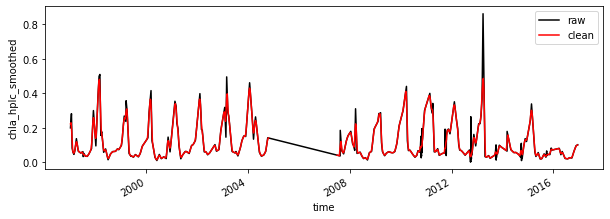

In [915]:
plt.figure(figsize=(10,3))
ds_bats.chla_hplc.plot(color='k',label='raw')
xds1_bats.plot(color='r',label='clean')
plt.legend()


In [916]:
# Define the new time grid with 8-day intervals
new_time = np.arange(ds_hot.time.min().values, ds_hot.time.max().values, np.timedelta64(8, 'D'))
# Interpolate onto the new time grid
ds_hot_8day = ds_hot.interp(time=new_time)
# Compute z-scores for the time series (remove funky outliers)
z_scores = np.abs(zscore(ds_hot_8day.chla_hplc, nan_policy='omit'))
ds_hot_8day['chla_hplc_cleaned'] = ds_hot_8day.chla_hplc.where(z_scores < 4)
ds_hot_8day['chla_hplc_cleaned'] = ds_hot_8day.chla_hplc_cleaned.interpolate_na(dim='time' ,method='linear')
# Rolling mean with a window of 3 time steps
ds_hot_8day['chla_hplc_smoothed'] = ds_hot_8day.chla_hplc_cleaned.rolling(time=3, center=True).mean()
xds1_hot = ds_hot_8day['chla_hplc_smoothed']#.where(~time_mask)
chl_clim_hot = xds1_hot.groupby(xds1_hot.time.dt.dayofyear).mean().rolling(dayofyear=30, min_periods=1, center=True,).mean()
chl_clim_max_hot = chl_clim_hot.idxmax(dim='dayofyear')


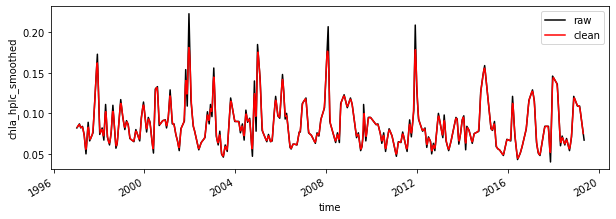

In [917]:
plt.figure(figsize=(10,3))
ds_hot.chla_hplc.plot(color='k',label='raw')
xds1_hot.plot(color='r',label='clean')
plt.legend()



In [918]:
# Step2: peak find
from scipy.signal import find_peaks

def peak_finder(arr, peak_distance=None, peak_percent=None, time_idx=None):

    if all(np.isnan(arr)):
        peak1 = np.nan
        peak2 = np.nan
        peak3 = np.nan

    else:
        arr_max = np.nanmax(arr) * peak_percent
        peaks, _ = find_peaks(arr, height=arr_max, distance=peak_distance)

        if len(peaks) == 0:
            peak1 = np.nan
            peak2 = np.nan
            peak3 = int(0)

        else:
            peak1 = int(np.array(peaks[0]))
            peak2 = int(np.array(peaks[-1]))
            peak3 = int(len(peaks))

            time_idx = time_idx
            peak1 = time_idx[peak1]
            peak2 = time_idx[peak2]


    return np.array([peak1, peak2, peak3])


# Find if peaks

In [919]:
# Run peak find on the moorings

In [920]:
# Define a function to process a specific mooring
def process_mooring_peaks(xds, chl_clim_max, mooring_name):
    years = np.unique(xds.time.dt.year.values)
    years = years[1:]  # Skip the first year

    init_peaks = []
    term_peaks = []
    num_peaks = []

    for y in years:
        ts = pd.to_datetime(str(y) + '-01-01T00:00:00')
        ts = ts.to_julian_date()

        # Use the mooring-specific chl_clim_max
        bmax = chl_clim_max.values

        if np.isnan(bmax):
            peaks = np.array([np.nan, np.nan, np.nan])
            idx_peaks = np.nan
            peaks2 = np.nan
        else:  
            bmax = bmax + ts
            bmax = pd.to_datetime(bmax, unit='D', origin='julian')

            idx1 = bmax - pd.Timedelta('183 days')
            idx2 = bmax + pd.Timedelta('183 days')

            bslice = xds.sel(time=slice(idx1, idx2))

            time_idx = bslice.time.values

            peaks = peak_finder(bslice, peak_distance=3, peak_percent=0.75, time_idx=time_idx)

            bdiff = bslice.diff(dim='time').dropna(dim='time').values
            idx_peaks = np.where(np.sign(bdiff[:-1]) != np.sign(bdiff[1:]))[0] + 1
            idx_peaks = len(idx_peaks)

        init_peaks.append(peaks[0])
        term_peaks.append(peaks[1])
        num_peaks.append(peaks[2])

    # Create an xarray Dataset for the mooring
    chl_peaks = xr.Dataset(
        data_vars=dict(
            initiation_peaks=("year", init_peaks), 
            termination_peaks=("year", term_peaks),
            num_peaks=("year", num_peaks)
        ),
        coords=dict(
            year=years
        ),
    )

    # Output the results
    print(f"Processed mooring peaks: {mooring_name}")
    return chl_peaks


In [921]:
chl_peaks_bats = process_mooring_peaks(xds1_bats, chl_clim_max_bats, "BATS")
chl_peaks_hot = process_mooring_peaks(xds1_hot, chl_clim_max_hot, "HOT")

Processed mooring peaks: BATS
Processed mooring peaks: HOT


# Step 3: bloom slice and phenology indices detection


In [922]:
def calculate_bloom_metrics(xds1, chl_peaks, outdir=None):
    """
    Calculate bloom initiation, termination, duration, integrated chl, mean chl, 
    max chl, and max chl time for three phenology methods (TS, CS, RC).
    
    Parameters:
    - xds1: xarray dataset containing chlorophyll data.
    - chl_peaks: xarray dataset containing bloom peak initiation and termination.
    - outdir: Directory to save output CSV files (optional). If None, returns the output as a DataFrame.

    Returns:
    - output_data: Pandas DataFrame containing bloom metrics if outdir is None.
    """

    # Initialize lists to store bloom data for all years
    bloom_init_ts, bloom_init_cs, bloom_init_rc = [], [], []
    bloom_term_ts, bloom_term_cs, bloom_term_rc = [], [], []
    bloom_dura_ts, bloom_dura_cs, bloom_dura_rc = [], [], []
    bloom_inte_ts, bloom_inte_cs, bloom_inte_rc = [], [], []
    bloom_mean_ts, bloom_mean_cs, bloom_mean_rc = [], [], []
    bloom_maxc, bloom_maxt = [], []

    # List of years to loop through
    years = np.unique(xds1.time.dt.year.values)
    years = years[1:]  # Exclude first year if necessary

    for year in years:
        # Extract data for the year
        cpeaks1 = chl_peaks.where(chl_peaks.initiation_peaks.year == year, drop=True).initiation_peaks[0]
        cpeaks2 = chl_peaks.where(chl_peaks.initiation_peaks.year == year, drop=True).termination_peaks[0]

        cdata = xds1  # Chlorophyll data

        # Bloom initiation
        idx1 = cpeaks1
        if idx1.isnull().any():
            b_init1, b_init2, b_init3 = np.nan, np.nan, np.nan
        else:
            idx2 = idx1 - pd.Timedelta('180 days')
            bslice = cdata.sel(time=slice(idx2, idx1)).interpolate_na(dim='time')

            if all(np.isnan(bslice)):
                b_init1, b_init2, b_init3 = np.nan, np.nan, np.nan
            else:
                # Biomass-based threshold method (TS)
                b_thresh = bslice.isel(time=bslice.argmin('time')) + (bslice.max() - bslice.min()) * 0.05
                b_init1 = (bslice.sortby('time', ascending=False) > b_thresh).idxmin().values

                # Cumulative biomass-based threshold method (CS)
                bslice = bslice[bslice.argmin().values:]
                bslice = bslice.where(bslice < bslice.median() * 3)
                b_cs = bslice.cumsum()
                b_thresh = b_cs.max() * 0.15
                b_init2 = (b_cs.sortby('time', ascending=True) > b_thresh).idxmax().values

                # Rate of change method (RC)
                tdiff = bslice.time.diff(dim='time') / np.timedelta64(1, 'D')
                bdiff = bslice.diff(dim='time') / tdiff
                b_thresh = bdiff.median() * 0.15
                b_init3 = (bdiff.sortby('time', ascending=True) > b_thresh).idxmin().values

        bloom_init_ts.append(b_init1)
        bloom_init_cs.append(b_init2)
        bloom_init_rc.append(b_init3)

        # Bloom termination
        idx1 = cpeaks2
        if idx1.isnull().any():
            b_term1, b_term2, b_term3 = np.nan, np.nan, np.nan
        else:
            idx2 = idx1 + pd.Timedelta('180 days')
            bslice = cdata.sel(time=slice(idx1.values, idx2)).interpolate_na(dim='time')

            if all(np.isnan(bslice)):
                b_term1, b_term2, b_term3 = np.nan, np.nan, np.nan
            else:
                # Biomass-based threshold method (TS)
                b_thresh = bslice.min() + ((bslice.max() - bslice.min()) * 0.05)
                b_term1 = (bslice.sortby('time', ascending=True) > b_thresh).idxmin().values

                # Cumulative biomass-based threshold method (CS)
                bslice = bslice[:bslice.argmin().values + 1]
                bslice = bslice.where(bslice < bslice.median() * 3)
                b_cs = bslice.cumsum()
                b_thresh = b_cs.max() * 0.85
                b_term2 = (b_cs.sortby('time', ascending=False) > b_thresh).idxmax().values

                # Rate of change method (RC)
                tdiff = bslice.time.diff(dim='time') / np.timedelta64(1, 'D')
                bdiff = bslice.diff(dim='time') / tdiff
                b_thresh = bdiff.median() * 0.15
                b_term3 = (bdiff.sortby('time', ascending=False) > b_thresh).idxmin().values

        bloom_term_ts.append(b_term1)
        bloom_term_cs.append(b_term2)
        bloom_term_rc.append(b_term3)

        # Bloom Duration, Integrated Chl, Mean Chl, Max Chl, Max Chl Time
        if np.isnan(b_init1) or np.isnan(b_term1) or np.isnan(b_init2) or np.isnan(b_term2) or np.isnan(b_init3) or np.isnan(b_term3):
            b_dura1, b_inte1, b_mean1 = np.nan, np.nan, np.nan
            b_dura2, b_inte2, b_mean2 = np.nan, np.nan, np.nan
            b_dura3, b_inte3, b_mean3 = np.nan, np.nan, np.nan
            b_max, b_mti = np.nan, np.nan
        else:
            # TS method
            b_dura1 = (b_term1 - b_init1) / np.timedelta64(1, 'D')
            bslice = cdata.sel(time=slice(b_init1, b_term1))
            b_max = bslice.max().values
            b_mti = bslice.idxmax().values
            idx = date2num(bslice.time.values)
            m = ~np.isnan(bslice).values
            b_inte1 = np.trapz(bslice[m], idx[m])
            b_mean1 = bslice.mean().values

            # CS method
            b_dura2 = (b_term2 - b_init2) / np.timedelta64(1, 'D')
            bslice = cdata.sel(time=slice(b_init2, b_term2))
            idx = date2num(bslice.time.values)
            m = ~np.isnan(bslice).values
            b_inte2 = np.trapz(bslice[m], idx[m])
            b_mean2 = bslice.mean().values

            # RC method
            b_dura3 = (b_term3 - b_init3) / np.timedelta64(1, 'D')
            bslice = cdata.sel(time=slice(b_init3, b_term3))
            idx = date2num(bslice.time.values)
            m = ~np.isnan(bslice).values
            b_inte3 = np.trapz(bslice[m], idx[m])
            b_mean3 = bslice.mean().values

        bloom_dura_ts.append(b_dura1)
        bloom_inte_ts.append(b_inte1)
        bloom_mean_ts.append(b_mean1)
        bloom_dura_cs.append(b_dura2)
        bloom_inte_cs.append(b_inte2)
        bloom_mean_cs.append(b_mean2)
        bloom_dura_rc.append(b_dura3)
        bloom_inte_rc.append(b_inte3)
        bloom_mean_rc.append(b_mean3)
        bloom_maxc.append(b_max)
        bloom_maxt.append(b_mti)

    output_data = pd.DataFrame({
        'bloom_init_ts': bloom_init_ts, 'bloom_term_ts': bloom_term_ts, 'bloom_dura_ts': bloom_dura_ts,
        'bloom_inte_ts': bloom_inte_ts, 'bloom_mean_ts': bloom_mean_ts, 'bloom_maxc': bloom_maxc, 
        'bloom_maxt': bloom_maxt, 'bloom_init_cs': bloom_init_cs, 'bloom_term_cs': bloom_term_cs,
        'bloom_dura_cs': bloom_dura_cs, 'bloom_inte_cs': bloom_inte_cs, 'bloom_mean_cs': bloom_mean_cs,
        'bloom_init_rc': bloom_init_rc, 'bloom_term_rc': bloom_term_rc, 'bloom_dura_rc': bloom_dura_rc,
        'bloom_inte_rc': bloom_inte_rc, 'bloom_mean_rc': bloom_mean_rc
    }, index=years)

    if outdir:
        output_data.to_csv(f"{outdir}/bloom_metrics.csv", index=True)
    else:
        return output_data


In [923]:
bats_pheno_mooring = calculate_bloom_metrics(xds1_bats, chl_peaks_bats, outdir=None)
hot_pheno_mooring = calculate_bloom_metrics(xds1_hot, chl_peaks_hot, outdir=None)

# Plots comparing difference

# Calculate the means satellitevs mooring

In [924]:
#make sure years with missing data in BATS are masked
bats_pheno_sat_c = bats_pheno_sat.sel(year=slice(1998,2016))
m = (bats_pheno_sat_c.year >= 2005) & (bats_pheno_sat_c.year <= 2008)
bats_pheno_sat_c = bats_pheno_sat_c.where(m==False,drop=True)

In [925]:
print('MOORING BATS (TS - detection):')
print('----------------------------------')
print('term ts: {:.2f} ± {:.2f}'.format(
    st.circmean(bats_pheno_mooring.bloom_term_ts.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(bats_pheno_mooring.bloom_term_ts.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('init ts: {:.2f} ± {:.2f}'.format(
    st.circmean(bats_pheno_mooring.bloom_init_ts.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(bats_pheno_mooring.bloom_init_ts.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('max time: {:.2f} ± {:.2f}'.format(
    st.circmean(bats_pheno_mooring.bloom_maxt.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(bats_pheno_mooring.bloom_maxt.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('duration: {:.2f} ± {:.2f}'.format(
    bats_pheno_mooring.bloom_dura_ts.mean(),
    bats_pheno_mooring.bloom_dura_ts.std()
))

print('\nOC-CCI BATS (TS - detection):')
print('----------------------------------')
print('term ts: {:.2f} ± {:.2f}'.format(
    st.circmean(bats_pheno_sat_c.termination_ts.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(bats_pheno_sat_c.termination_ts.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('init ts: {:.2f} ± {:.2f}'.format(
    st.circmean(bats_pheno_sat_c.initiation_ts.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(bats_pheno_sat_c.initiation_ts.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('max time: {:.2f} ± {:.2f}'.format(
    st.circmean(bats_pheno_sat_c.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(bats_pheno_sat_c.max_time.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('duration: {:.2f} ± {:.2f}'.format(
    bats_pheno_sat_c.duration_ts.mean().values,
    bats_pheno_sat_c.duration_ts.std().values
))


MOORING BATS (TS - detection):
----------------------------------
term ts: 158.61 ± 30.82
init ts: 271.68 ± 30.44
max time: 63.52 ± 18.48
duration: 254.50 ± 48.90

OC-CCI BATS (TS - detection):
----------------------------------
term ts: 166.68 ± 30.29
init ts: 257.09 ± 22.88
max time: 45.30 ± 35.83
duration: 274.87 ± 32.26


In [899]:
print('MOORING HOT:')
print('-----------------')
print('term ts: {:.2f} ± {:.2f}'.format(
    st.circmean(hot_pheno_mooring.bloom_term_ts.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(hot_pheno_mooring.bloom_term_ts.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('init ts: {:.2f} ± {:.2f}'.format(
    st.circmean(hot_pheno_mooring.bloom_init_ts.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(hot_pheno_mooring.bloom_init_ts.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('max time: {:.2f} ± {:.2f}'.format(
    st.circmean(hot_pheno_mooring.bloom_maxt.dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(hot_pheno_mooring.bloom_maxt.dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('duration ts: {:.2f} ± {:.2f}'.format(
    hot_pheno_mooring.bloom_dura_ts.mean(),
    hot_pheno_mooring.bloom_dura_ts.std()
))

print('OC-CCI HOT:')
print('-----------------')
print('term ts: {:.2f} ± {:.2f}'.format(
    st.circmean(hot_pheno_sat.termination_ts[1:-2].dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(hot_pheno_sat.termination_ts[1:-2].dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('init ts: {:.2f} ± {:.2f}'.format(
    st.circmean(hot_pheno_sat.initiation_ts[1:-2].dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(hot_pheno_sat.initiation_ts[1:-2].dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('max time: {:.2f} ± {:.2f}'.format(
    st.circmean(hot_pheno_sat.max_time[1:-2].dt.dayofyear, high=365, low=1, nan_policy='omit'),
    st.circstd(hot_pheno_sat.max_time[1:-2].dt.dayofyear, high=365, low=1, nan_policy='omit')
))
print('duration ts: {:.2f} ± {:.2f}'.format(
    hot_pheno_sat.duration_ts[1:-2].mean().values,
    hot_pheno_sat.duration_ts[1:-2].std().values
))


MOORING HOT:
-----------------
term ts: 143.33 ± 32.39
init ts: 205.66 ± 48.60
max time: 347.41 ± 55.26
duration ts: 299.81 ± 64.87
OC-CCI HOT:
-----------------
term ts: 158.79 ± 29.09
init ts: 203.38 ± 42.82
max time: 340.91 ± 35.07
duration ts: 303.29 ± 67.04


## Plot time series

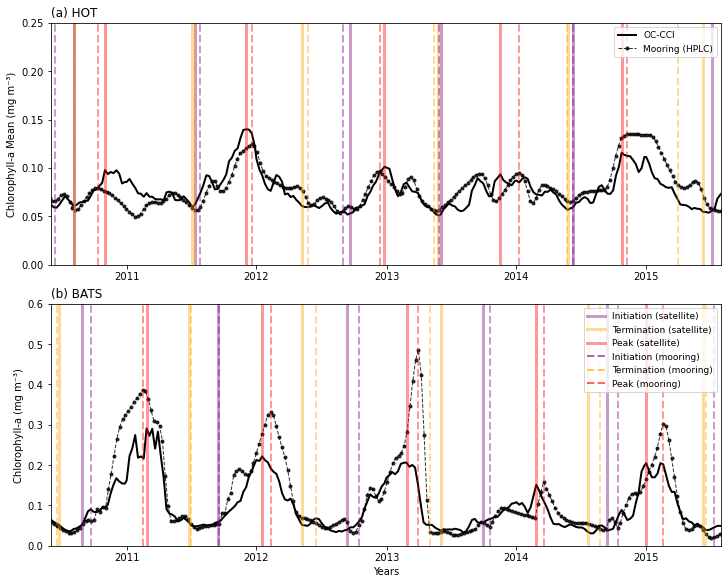

In [903]:
import matplotlib.pyplot as plt
import pandas as pd
years_hot = np.arange(1998,2019)  
years_bats = np.arange(2009,2017)  

# Define the plotting function
def plot_chlorophyll_time_series():
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

    # Hawaiian Ocean Time-series (HOT)
    lat_hot = 22.75
    lon_hot = -158
    region_hot = chl_25km.chlor_a.sel(lat=lat_hot, lon=lon_hot, method='nearest')
    r1_hot = region_hot.sel(time=slice('1999-06-01', '2022-07-31')).to_dataframe()

    # Extract phenology indices for HOT (all years)
    hot_pheno = PHENO_25KM.sel(lat=lat_hot, lon=lon_hot, method='nearest')
    years = pd.date_range(start='1998-01-01', end='2022-12-31', freq='Y').year

    axs[0].plot(r1_hot.index, r1_hot['chlor_a'], color='k', lw=2, label='OC-CCI')
    axs[0].plot(pd.to_datetime(xds1_hot['time']), xds1_hot,
                color='k', marker='.', ls='--', lw=1, alpha=0.8, label='Mooring (HPLC)')

    # Add vertical lines for each year's phenology events (satellite)
    for year in years_hot:
        init_hot = pd.to_datetime(hot_pheno.initiation_ts.sel(year=year).values)
        term_hot = pd.to_datetime(hot_pheno.termination_ts.sel(year=year).values)
        peak_hot = pd.to_datetime(hot_pheno.max_time.sel(year=year).values)

        # Satellite vertical lines (solid)
        if not pd.isnull(init_hot):
            axs[0].axvline(pd.to_datetime(init_hot), color='purple', linestyle='-', lw=3, alpha=0.4)
        if not pd.isnull(term_hot):
            axs[0].axvline(pd.to_datetime(term_hot), color='orange', linestyle='-', lw=3, alpha=0.4)
        if not pd.isnull(peak_hot):
            axs[0].axvline(pd.to_datetime(peak_hot), color='red', linestyle='-', lw=3, alpha=0.4)

    # Add vertical dashed lines for mooring phenology indices
    for year in years_hot:
        i = hot_pheno_mooring.bloom_init_ts.index==year
        init_hot_mooring = pd.to_datetime(hot_pheno_mooring.bloom_init_ts[i].values)
        term_hot_mooring = pd.to_datetime(hot_pheno_mooring.bloom_term_ts[i].values)
        peak_hot_mooring = pd.to_datetime(hot_pheno_mooring.bloom_maxt[i].values)

        # Mooring vertical lines (dashed)
        if not pd.isnull(init_hot_mooring):
            axs[0].axvline(pd.to_datetime(init_hot_mooring), color='purple', linestyle='--', lw=2, alpha=0.4)
        if not pd.isnull(term_hot_mooring):
            axs[0].axvline(pd.to_datetime(term_hot_mooring), color='orange', linestyle='--', lw=2, alpha=0.4)
        if not pd.isnull(peak_hot_mooring):
            axs[0].axvline(pd.to_datetime(peak_hot_mooring), color='red', linestyle='--', lw=2, alpha=0.4)

    axs[0].set_xlim(pd.to_datetime('2010-06-01'), pd.to_datetime('2015-07-31'))
    axs[0].set_ylim(0, 0.25)
    axs[0].set_title('(a) HOT', loc='left', fontsize=12)
    axs[0].set_ylabel('Chlorophyll-a Mean (mg m⁻³)', fontsize=10)
    axs[0].legend(fontsize=9)

    # Bermuda Atlantic Time-series (BATS)
    lat_bats = 31.667
    lon_bats = -64.1667
    region_bats = chl_25km.chlor_a.sel(lat=lat_bats, lon=lon_bats, method='nearest')
    r1_bats = region_bats.sel(time=slice('2000-06-15', '2019-07-31')).to_dataframe()

    # Extract phenology indices for BATS (all years)
    bats_pheno = PHENO_25KM.sel(lat=lat_bats, lon=lon_bats, method='nearest')

    axs[1].plot(r1_bats.index, r1_bats['chlor_a'], color='k', lw=2, label='OC-CCI')
    axs[1].plot(pd.to_datetime(xds1_bats['time']), xds1_bats,
                color='k', marker='.', ls='--', lw=1, alpha=0.8, label='Mooring (HPLC)')

    # Add vertical lines for each year's phenology events (satellite)
    for year in years_bats:
        init_bats = pd.to_datetime(bats_pheno.initiation_ts.sel(year=year).values)
        term_bats = pd.to_datetime(bats_pheno.termination_ts.sel(year=year).values)
        peak_bats = pd.to_datetime(bats_pheno.max_time.sel(year=year).values)

        # Satellite vertical lines (solid)
        if not pd.isnull(init_bats):
            axs[1].axvline(pd.to_datetime(init_bats), color='purple', linestyle='-', lw=3, alpha=0.4)
        if not pd.isnull(term_bats):
            axs[1].axvline(pd.to_datetime(term_bats), color='orange', linestyle='-', lw=3, alpha=0.4)
        if not pd.isnull(peak_bats):
            axs[1].axvline(pd.to_datetime(peak_bats), color='red', linestyle='-', lw=3, alpha=0.4)

    # Add vertical dashed lines for mooring phenology indices
    for year in years_bats:
        i = bats_pheno_mooring.bloom_init_ts.index==year
        init_bats_mooring = pd.to_datetime(bats_pheno_mooring.bloom_init_ts[i].values)
        term_bats_mooring = pd.to_datetime(bats_pheno_mooring.bloom_term_ts[i].values)
        peak_bats_mooring = pd.to_datetime(bats_pheno_mooring.bloom_maxt[i].values)
        
        # Mooring vertical lines (dashed)
        if not pd.isnull(init_bats_mooring):
            axs[1].axvline(pd.to_datetime(init_bats_mooring), color='purple', linestyle='--', lw=2, alpha=0.4)
        if not pd.isnull(term_bats_mooring):
            axs[1].axvline(pd.to_datetime(term_bats_mooring), color='orange', linestyle='--', lw=2, alpha=0.4)
        if not pd.isnull(peak_bats_mooring):
            axs[1].axvline(pd.to_datetime(peak_bats_mooring), color='red', linestyle='--', lw=2, alpha=0.4)

    # Add legend for phenology indices
    phenology_legend = [
        plt.Line2D([0], [0], color='purple', linestyle='-', lw=3, alpha=0.4, label='Initiation (satellite)'),
        plt.Line2D([0], [0], color='orange', linestyle='-', lw=3, alpha=0.4, label='Termination (satellite)'),
        plt.Line2D([0], [0], color='red', linestyle='-', lw=3, alpha=0.4, label='Peak (satellite)'),
        plt.Line2D([0], [0], color='purple', linestyle='--', lw=2, alpha=0.6, label='Initiation (mooring)'),
        plt.Line2D([0], [0], color='orange', linestyle='--', lw=2, alpha=0.6, label='Termination (mooring)'),
        plt.Line2D([0], [0], color='red', linestyle='--', lw=2, alpha=0.6, label='Peak (mooring)')
    ]

    axs[1].legend(handles=phenology_legend, loc='upper right', fontsize=9)

    axs[1].set_xlim(pd.to_datetime('2010-06-01'), pd.to_datetime('2015-07-31'))
    axs[1].set_ylim(0, 0.6)
    axs[1].set_title('(b) BATS', loc='left', fontsize=12)
    axs[1].set_xlabel('Years', fontsize=10)
    axs[1].set_ylabel('Chlorophyll-a (mg m⁻³)', fontsize=10)

    # Add overall title
    #plt.suptitle('Chlorophyll-a Time Series with Yearly Phenology Indices', fontsize=14)
    plt.show()

# Call the function to plot
plot_chlorophyll_time_series()
fig.savefig(fig_dir + 'FIGUREA2_NEW_R2_COMPARE_MOORINGPHENO.png', dpi=300, bbox_inches='tight')



# SECTION 3.4: Resolution 4km, 9km and 25km

# Figure 4 
#### PDF: 24 km, 9km, 4 km  (duration, mean bloom and SCR)


In [842]:
# Mean Bloom: 
#-----
#define random sample of data (remove last and first year of phenology)
chlm_data2 = PHENO_25KM.mean_chl_ts[1:-1,::].mean(['year']).to_series().dropna().reset_index(drop=True)
chlm_data2 = PHENO_9KM.mean_chl_ts[1:-1,::].mean(['year']).to_series().dropna().reset_index(drop=True)
chlm_data3 =  PHENO_4KM.mean_chl_ts[1:-1,::].mean(['year']).to_series().dropna().reset_index(drop=True)


In [843]:
# Duration of Bloom: 
#-----
#define random sample of data
durationm_data1 = PHENO_25KM_MEAN.duration_ts[1:-1,::].to_series().dropna().reset_index(drop=True) 
durationm_data2 = PHENO_9KM.duration_ts[1:-1,::].mean(['year']).to_series().dropna().reset_index(drop=True)
durationm_data3 = PHENO_4KM.duration_ts[1:-1,::].mean(['year']).to_series().dropna().reset_index(drop=True)


In [846]:
# SCR: 
#-----
#define random sample of data
scr_data1 = SCR_25KM.chlor_a[1:-1,::].mean('year').to_series().dropna().reset_index(drop=True) * 100
scr_data2 = SCR_9KM.chlor_a[1:-1,::].mean('year').to_series().dropna().reset_index(drop=True) * 100
scr_data3 = SCR_4KM.chlor_a[1:-1,::].mean('year').to_series().dropna().reset_index(drop=True) * 100


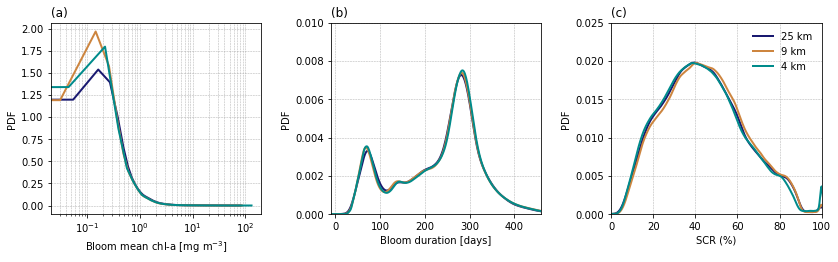

In [847]:
import matplotlib.pyplot as plt

colors = ['midnightblue', 'peru', 'darkcyan']

fig, ax = plt.subplots(1, 3, figsize=[12, 4])

# Panel (a) - Log scale for y-axis
chlm_data1.plot.kde(ax=ax[0], color=colors[0], label='25 km', linewidth=2)
chlm_data2.plot.kde(ax=ax[0], color=colors[1], label='9 km', linewidth=2)
chlm_data3.plot.kde(ax=ax[0], color=colors[2], label='4 km', linewidth=2)
#ax[0].set_xlim(0, 100)
ax[0].set_xscale('log')  # Log scale for better visualization
ax[0].set_ylabel('PDF')
ax[0].set_xlabel('Bloom mean chl-a [mg m$^{-3}$]')
ax[0].set_title('(a)', loc='left', fontsize=12)
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Panel (b)
durationm_data1.plot.kde(ax=ax[1], color=colors[0], label='25 km', linewidth=2)
durationm_data2.plot.kde(ax=ax[1], color=colors[1], label='9 km', linewidth=2)
durationm_data3.plot.kde(ax=ax[1], color=colors[2], label='4 km', linewidth=2)
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('Bloom duration [days]')
ax[1].set_xlim(-10, 460)
ax[1].set_ylim(0, 0.01)
ax[1].set_title('(b)', loc='left', fontsize=12)
ax[1].grid(True, linestyle='--', linewidth=0.5)

# Panel (c)
scr_data1.plot.kde(ax=ax[2], color=colors[0], label='25 km', linewidth=2)
scr_data2.plot.kde(ax=ax[2], color=colors[1], label='9 km', linewidth=2)
scr_data3.plot.kde(ax=ax[2], color=colors[2], label='4 km', linewidth=2)
ax[2].set_xlim(0, 100)
ax[2].set_ylim(0, 0.025)
ax[2].set_ylabel('PDF')
ax[2].set_xlabel('SCR (%)')
ax[2].legend(loc='upper right', fontsize=10, frameon=False)
ax[2].set_title('(c)', loc='left', fontsize=12)
ax[2].grid(True, linestyle='--', linewidth=0.5)

# Improve layout
fig.tight_layout(pad=2.0)
fig.savefig(fig_dir + 'FIGURE4_R2_ESSD_PHENOLOGY_RESOLUTION_PDF.png', dpi=300, bbox_inches='tight')

plt.show()


## Figure 5: Subdomains Resolution

Calculate mean initaitons for different resolution:

In [848]:
intchl_ts_25KM = PHENO_25KM.int_chl_ts[1:-1,::].mean('year') 
intchl_ts_9KM = PHENO_9KM.int_chl_ts[1:-1,::].mean('year') 
intchl_ts_4KM = PHENO_4KM.int_chl_ts[1:-1,::].mean('year') 


dura_ts_25KM = PHENO_25KM.duration_ts[1:-1,::].mean('year') 
dura_ts_9KM = PHENO_9KM.duration_ts[1:-1,::].mean('year') 
dura_ts_4KM = PHENO_4KM.duration_ts[1:-1,::].mean('year') 


/apps/user/erth0834/anaconda3-2021.05/envs/bp12_eval/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/apps/user/erth0834/anaconda3-2021.05/envs/bp12_eval/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/var/tmp/pbs.6302016.sched01/ipykernel_17558/3765674359.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([14,16,18])
/var/tmp/pbs.6302016.sched01/ipykernel_17558/3765674359.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/tmp/pbs.6302016.sched01/ipykernel_17558/37656

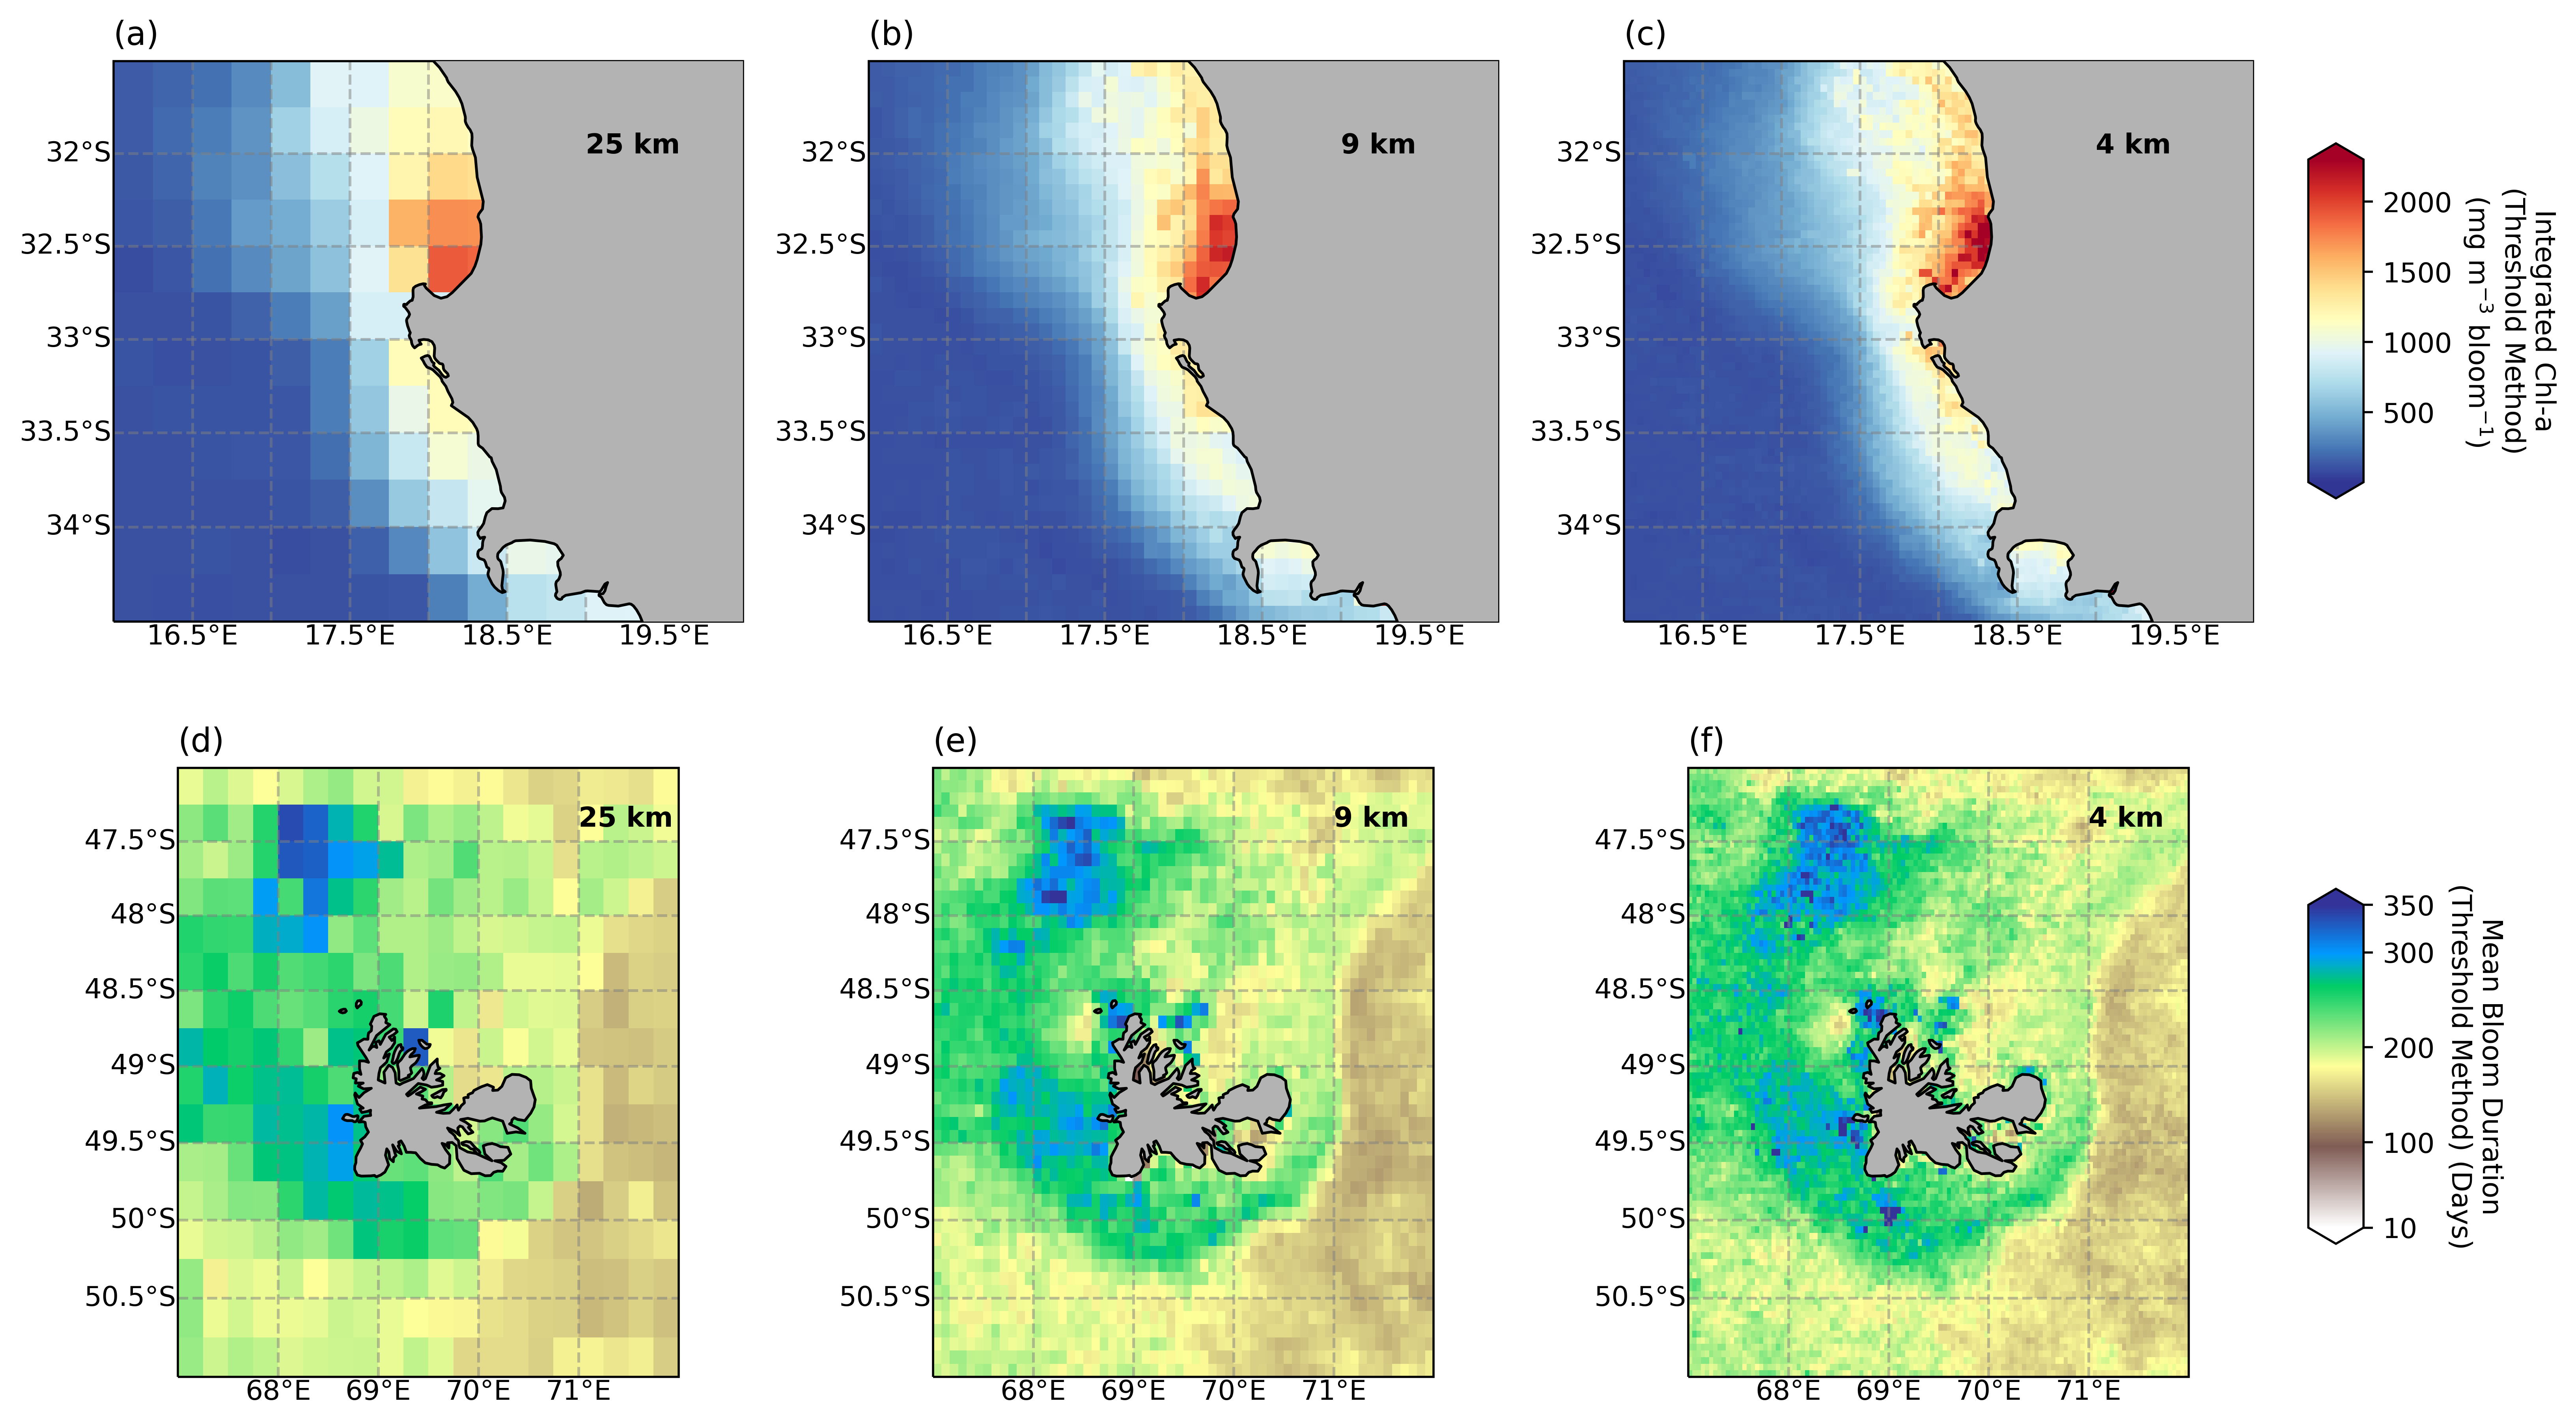

In [849]:
fig = figure(figsize=[14, 9], dpi=500)
ax1 = subplot2grid((2,3), (0,0), projection=ccrs.Mercator())

ax1.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im=intchl_ts_25KM.sel(lon=slice(14, 20),lat=slice(-35,-27)).plot(cmap=cm.RdYlBu_r, vmax=2300,vmin=1,transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_title('(a)',loc='left')
ax1.set_extent([16, 20, -31.5, -34.5], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.fontsize = 9
ax1.text(19,-32,'25 km',fontweight='bold',transform=ccrs.PlateCarree(),zorder=7)
#
ax2 = subplot2grid((2,3), (0,1), projection=ccrs.Mercator())
ax2.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im=intchl_ts_9KM.sel(lon=slice(14, 20),lat=slice(-27,-35)).plot(cmap=cm.RdYlBu_r, vmax=2300,vmin=1,transform=ccrs.PlateCarree(),add_colorbar=False)
#im = PHENO_9KM_MEAN.initiation_ts.sel(lon=slice(12, 20),lat=slice(-27,-35)).plot(ax=ax2, transform=ccrs.PlateCarree(),add_colorbar=False, vmin=1, vmax=365, cmap=cm.terrain_r)
ax2.set_title('(b)',loc='left')
ax2.set_extent([16, 20, -31.5, -34.5], crs=ccrs.PlateCarree())
ax2.set_xticklabels([14,16,18])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
##gl.ypadding=5
gl.fontsize = 9
ax2.text(19,-32,'9 km',fontweight='bold',transform=ccrs.PlateCarree(),zorder=7)
#
#
ax3 = subplot2grid((2,3), (0,2), projection=ccrs.Mercator())
ax3.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = intchl_ts_4KM.sel(lon=slice(14, 20),lat=slice(-27,-35)).plot(cmap=cm.RdYlBu_r, vmax=2300,vmin=1,transform=ccrs.PlateCarree(),add_colorbar=False)
ax3.set_title('(c)',loc='left')
ax3.set_extent([16, 20, -31.5, -34.5], crs=ccrs.PlateCarree())
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.fontsize = 9
ax3.text(19,-32,'4 km',fontweight='bold',transform=ccrs.PlateCarree(),zorder=7)
#
#
cbar_ax = fig.add_axes([.92, 0.62, 0.02, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax, extend='both')
cbar.set_label('Integrated Chl-a\n(Threshold Method)\n(mg m$^{-3}$ bloom$^{-1}$)', labelpad=38, rotation=270)
#cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

#------------------------------------------------------

ax4 = subplot2grid((2,3), (1,0), projection=ccrs.Mercator())
ax4.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = dura_ts_25KM.sel(lat=slice(-51,-47),lon=slice(67,72)).plot(ax=ax4, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r,)
ax4.set_title('(d)',loc='left')
ax4.set_extent([67,72,-51,-47], crs=ccrs.PlateCarree())

gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.fontsize = 9
ax4.text(71,-47.4,'25 km',fontweight='bold',transform=ccrs.PlateCarree(),zorder=7)

ax5 = subplot2grid((2,3), (1,1), projection=ccrs.Mercator())
ax5.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = dura_ts_9KM.sel(lat=slice(-47,-51),lon=slice(67,72)).plot(ax=ax5, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r,)
ax5.set_title('(e)',loc='left')
ax5.set_extent([67,72,-51,-47], crs=ccrs.PlateCarree())
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.fontsize = 9
ax5.plot(-16.5,48.8333,'ok', transform=ccrs.PlateCarree())
ax5.text(71,-47.4,'9 km',fontweight='bold',transform=ccrs.PlateCarree(),zorder=7)

ax6 = subplot2grid((2,3), (1,2), projection=ccrs.Mercator())
ax6.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='0.7'), zorder=5)
im = dura_ts_4KM.sel(lat=slice(-47,-51),lon=slice(67,72)).plot(ax=ax6, transform=ccrs.PlateCarree(), 
                               add_colorbar=False, vmin=10, vmax=350, cmap=cm.terrain_r,)

cbar_ax = fig.add_axes([.92, 0.2, 0.02, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', shrink=0.3, ticks=[10, 100, 200, 300, 350])
cbar.set_label('Mean Bloom Duration\n(Threshold Method) (Days)', rotation=270, labelpad=25)

ax6.set_extent([67,72,-51,-47], crs=ccrs.PlateCarree())
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.fontsize = 9
ax6.set_title('(f)',loc='left')
ax6.text(71,-47.4,'4 km',fontweight='bold',transform=ccrs.PlateCarree(),zorder=7)


fig.tight_layout()
fig.savefig(fig_dir+'FIGURE5_R2.png',dpi=500)
